In [ ]:
import scanpy as sc
import pandas as pd
from scipy.io import mmread
import anndata as ad
import os
from glob import glob
import numpy as np

def extract_project_id_from_path(path):
    """从路径中提取项目ID（如1182992）"""
    parts = path.split('/')
    sample_full = parts[-3]  # 获取如1182992_1
    project_id = sample_full.split('_')[0]  # 分割得到1182992
    return project_id

def read_10x_mtx(matrix_dir):
    """从指定目录读取10x Genomics数据"""
    try:
        barcodes_path = os.path.join(matrix_dir, "barcodes.tsv.gz")
        features_path = os.path.join(matrix_dir, "features.tsv.gz")
        matrix_path = os.path.join(matrix_dir, "matrix.mtx.gz")
        
        barcodes = pd.read_csv(barcodes_path, header=None, sep='\t')[0].values
        features = pd.read_csv(features_path, header=None, sep='\t')
        genes = features[0].values
        matrix = mmread(matrix_path).tocsr()
        adata = sc.AnnData(X=matrix.T, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=genes))
        return adata
    except Exception as e:
        print(f"读取数据出错: {str(e)}")
        return None

def process_sample_group(samples, project_id):
    """处理单个样本组（可能包含多个重复）"""
    adatas = {}
    
    # 处理每个重复样本
    for w_number, sample_full, path in samples:
        matrix_dir = path
        sample_name = sample_full  # 保留原始样本名如1182992_1
        
        print(f"\n处理样本: {sample_name}")
        print(f"样本路径: {matrix_dir}")
        
        # 检查文件是否存在
        required_files = ["barcodes.tsv.gz", "features.tsv.gz", "matrix.mtx.gz"]
        missing_files = [f for f in required_files if not os.path.exists(os.path.join(matrix_dir, f))]
        
        if missing_files:
            print(f"错误: 缺少文件: {missing_files}")
            continue
        
        # 读取数据
        sample_adata = read_10x_mtx(matrix_dir)
        if sample_adata is None:
            continue
            
        sample_adata.var_names_make_unique()
        sample_adata.obs["sample"] = project_id  # Modified: 存储纯ID（如1182992）
        sample_adata.obs["batch"] = sample_name   # Modified: 存储带重复信息的ID（如1182992_1）
        adatas[sample_name] = sample_adata
        print(f"成功处理样本: {sample_name}")
    
    if not adatas:
        print("该样本组没有有效数据")
        return None
    
    # 如果有多个重复则合并，否则直接使用
    if len(adatas) > 1:
        print(f"\n=== 合并样本组 {project_id} 的 {len(adatas)} 个重复 ===")
        adata = ad.concat(adatas.values(), label="batch")  # Modified: 使用batch_key="batch"
        adata.obs_names_make_unique()
    else:
        print(f"\n=== 样本组 {project_id} 只有1个重复，直接使用 ===")
        adata = list(adatas.values())[0]
    
    return adata

def process_samples(root_path="/data/input"):
    all_results = {}
    
    # 查找所有可能的样本目录
    sample_dirs = glob(os.path.join(root_path, "W*", "scRNA-seq_v3", "*", "02.count", "filter_matrix"))
    
    if not sample_dirs:
        print("错误: 未找到任何样本目录")
        return None
    
    # 设置工作目录
    os.makedirs(f"/data/work/final/01_single_filter/normal", exist_ok=True)
    os.chdir(f"/data/work/final/01_single_filter/normal")
    print("当前工作目录:", os.getcwd())
    
    # 按样本ID分组（去掉_1/_2后缀）
    sample_groups = {}
    for path in sample_dirs:
        parts = path.split('/')
        sample_full = parts[-3]  # 如1182992_1或1182992
        sample_base = sample_full.split('_')[0]  # 如1182992
        w_number = parts[-5]  # 如W202504290001468
        
        if sample_base not in sample_groups:
            sample_groups[sample_base] = []
        sample_groups[sample_base].append((w_number, sample_full, path))
    
    # 处理每个样本组
    for sample_base, samples in sample_groups.items():
        print(f"\n===== 开始处理样本组: {sample_base} =====")
        
        # 处理当前样本组
        adata = process_sample_group(samples, sample_base)
        if adata is None:
            continue
        
        # 质量控制分析
        print("\n=== 执行质量控制分析 ===")
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=["mt"], inplace=True, log1p=False
        )
        
        # 绘制QC图
        print("\n=== 生成质量控制图 ===")
        sc.pl.violin(
            adata,
            ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
            jitter=0.4,
            multi_panel=True,
            save=f"_QC_{sample_base}.png"
        )
        
        # 过滤
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_cells(adata, max_genes=8000)
        sc.pp.filter_genes(adata, min_cells=3)
        adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
        
        # 查看过滤后的平均基因数
        n_genes_per_cell = (adata.X > 0).sum(axis=1)
        average_genes_per_cell = np.mean(n_genes_per_cell)
        print("\n=== 过滤后平均基因数 ===")
        print(average_genes_per_cell)
        
        # 去除双胞
        sc.external.pp.scrublet(adata, batch_key="batch")  # Modified: 使用batch_key="batch"
        
        # 删除线粒体基因，以及带HBB,HBA基因的细胞
        adata.var['hb'] = adata.var_names.isin(['HBB', 'HBA1', 'HBA2'])  # 血红蛋白基因
        sc.pp.calculate_qc_metrics(adata, qc_vars=['hb'], inplace=True)  # Modified: 确保计算hb基因的QC指标
        adata = adata[adata.obs['total_counts_hb'] == 0, :]

        # 从变量中删除这些基因
        genes_to_keep = ~adata.var['mt'] & ~adata.var['hb']
        adata = adata[:, genes_to_keep]
        
        # 保存结果
        output_dir = "/data/work/final/02_integrate_sample/single_normal"
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{sample_base}.h5ad")
        adata.write_h5ad(output_path)
        print(f"\n=== 结果已保存到: {output_path} ===")
        
        # 打印样本信息
        print("\n=== 样本统计信息 ===")
        print(adata.obs["sample"].value_counts())
        print("\n=== 处理后的adata对象 ===")
        print(adata)
        
        all_results[sample_base] = adata
    
    return all_results

# 执行处理
results = process_samples()

当前工作目录: /data/work/final/01_single_filter/normal

===== 开始处理样本组: 662 =====

处理样本: 662_1
样本路径: /data/input/W202410140003519/scRNA-seq_v3/662_1/02.count/filter_matrix
成功处理样本: 662_1

处理样本: 662_2
样本路径: /data/input/W202410140003520/scRNA-seq_v3/662_2/02.count/filter_matrix
成功处理样本: 662_2

=== 合并样本组 662 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


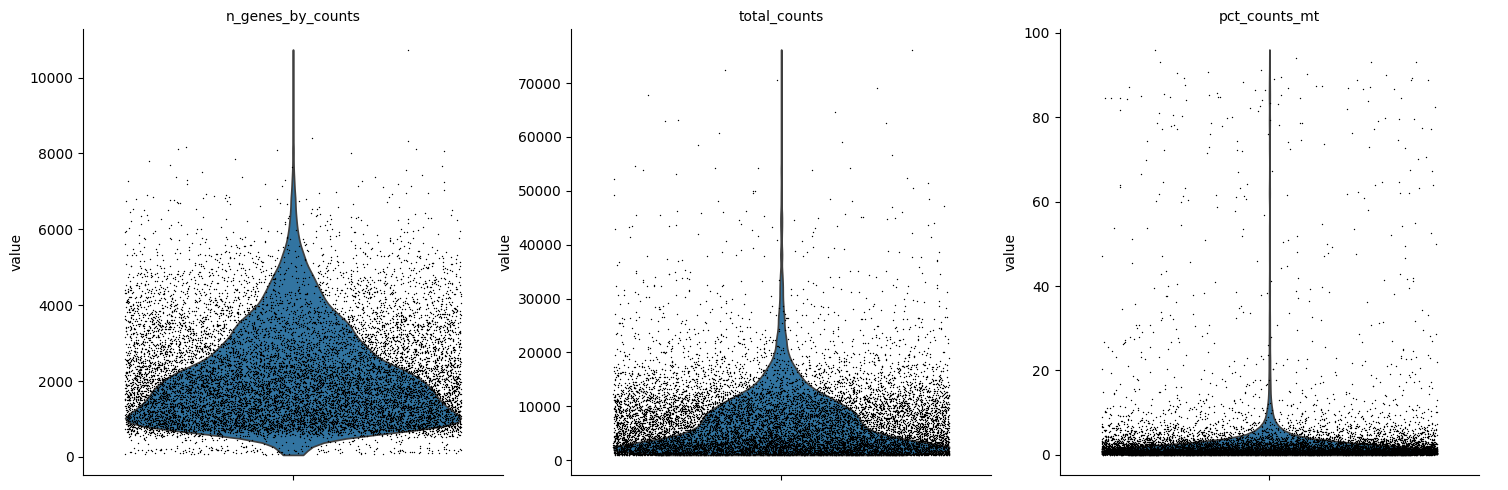


=== 过滤后平均基因数 ===
2194.129161220881


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/662.h5ad ===

=== 样本统计信息 ===
sample
662    13007
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 13007 × 37857
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 868 =====

处理样本: 868
样本路径: /data/input/W202410140003521/scRNA-seq_v3/868/02.count/filter_matrix
成功处理样本: 868

=== 样本组 868 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


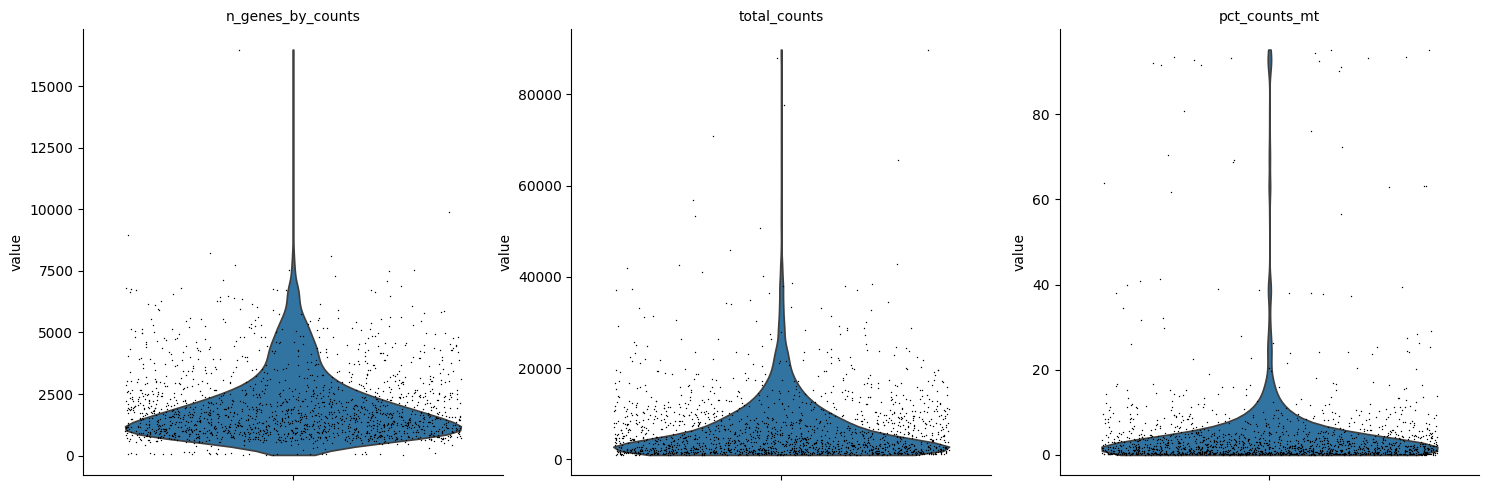


=== 过滤后平均基因数 ===
2116.2743475493317


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/868.h5ad ===

=== 样本统计信息 ===
sample
868    1571
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 1571 × 31506
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 781 =====

处理样本: 781
样本路径: /data/input/W202410140003516/scRNA-seq_v3/781/02.count/filter_matrix
成功处理样本: 781

=== 样本组 781 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


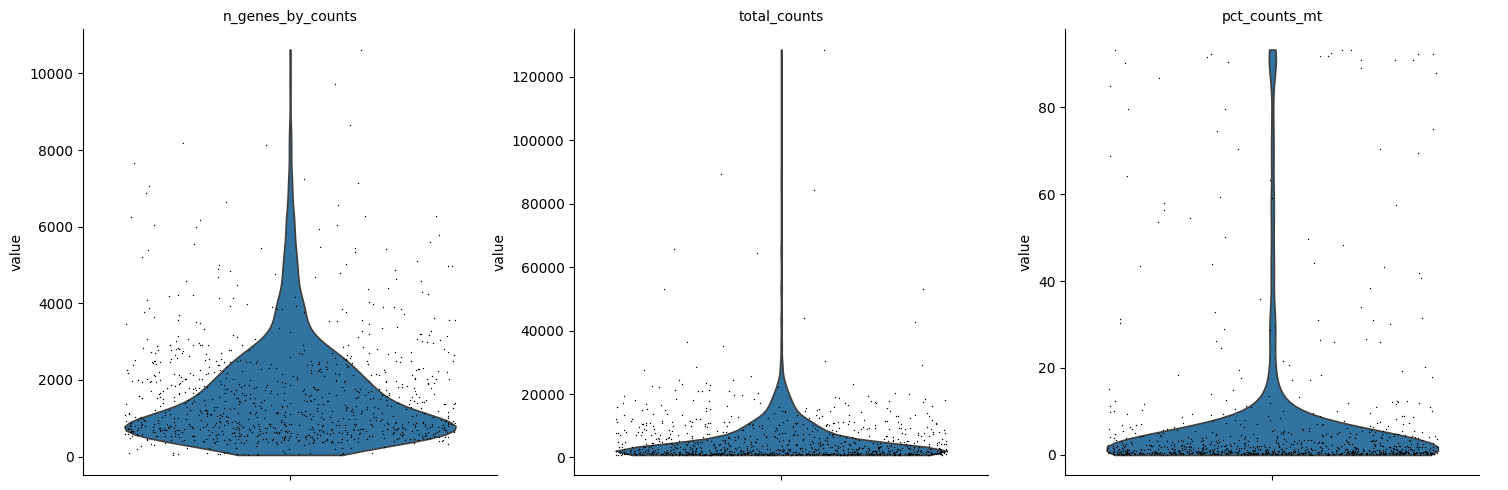


=== 过滤后平均基因数 ===
1671.2114285714285


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/781.h5ad ===

=== 样本统计信息 ===
sample
781    875
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 875 × 27379
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1174019 =====

处理样本: 1174019
样本路径: /data/input/W202503270001605/scRNA-seq_v3/1174019/02.count/filter_matrix
成功处理样本: 1174019

=== 样本组 1174019 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


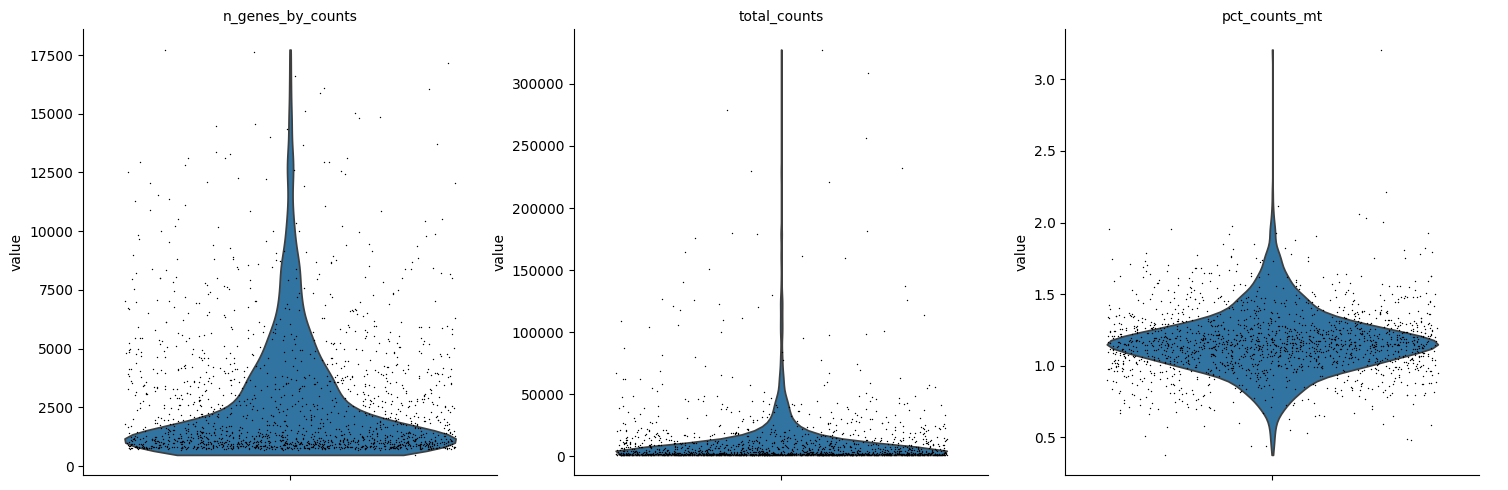


=== 过滤后平均基因数 ===
2236.381669805399


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1174019.h5ad ===

=== 样本统计信息 ===
sample
1174019    1593
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 1593 × 27082
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1174264 =====

处理样本: 1174264
样本路径: /data/input/W202503270001609/scRNA-seq_v3/1174264/02.count/filter_matrix
成功处理样本: 1174264

=== 样本组 1174264 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


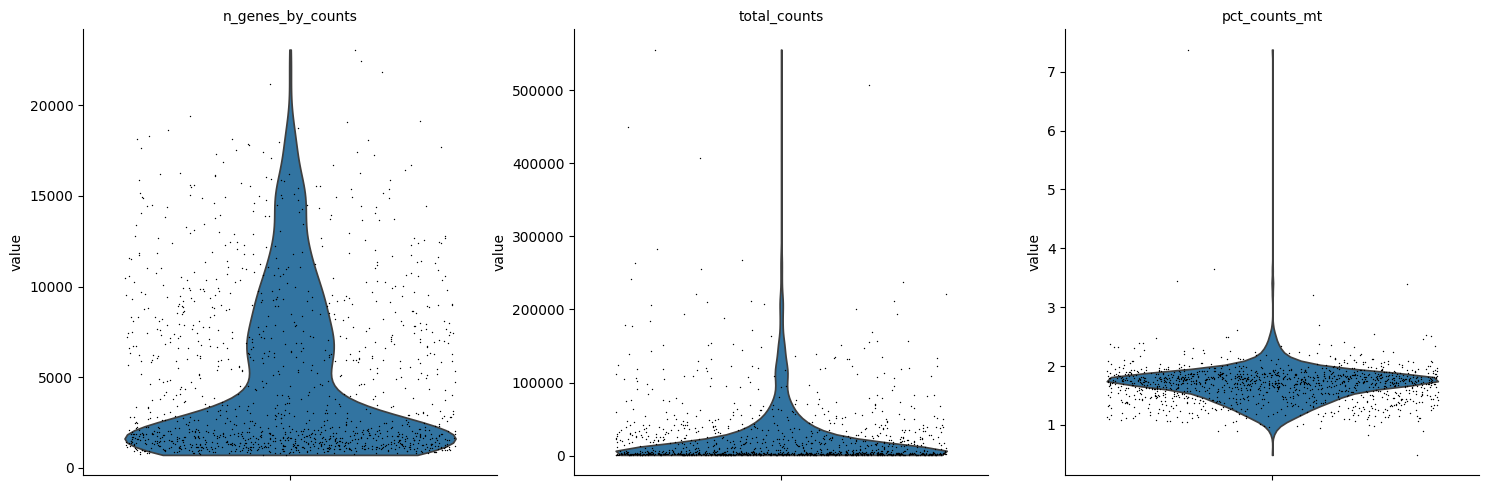


=== 过滤后平均基因数 ===
2788.3329949238578


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1174264.h5ad ===

=== 样本统计信息 ===
sample
1174264    985
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 985 × 28574
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1174369 =====

处理样本: 1174369
样本路径: /data/input/W202503270001608/scRNA-seq_v3/1174369/02.count/filter_matrix
成功处理样本: 1174369

=== 样本组 1174369 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


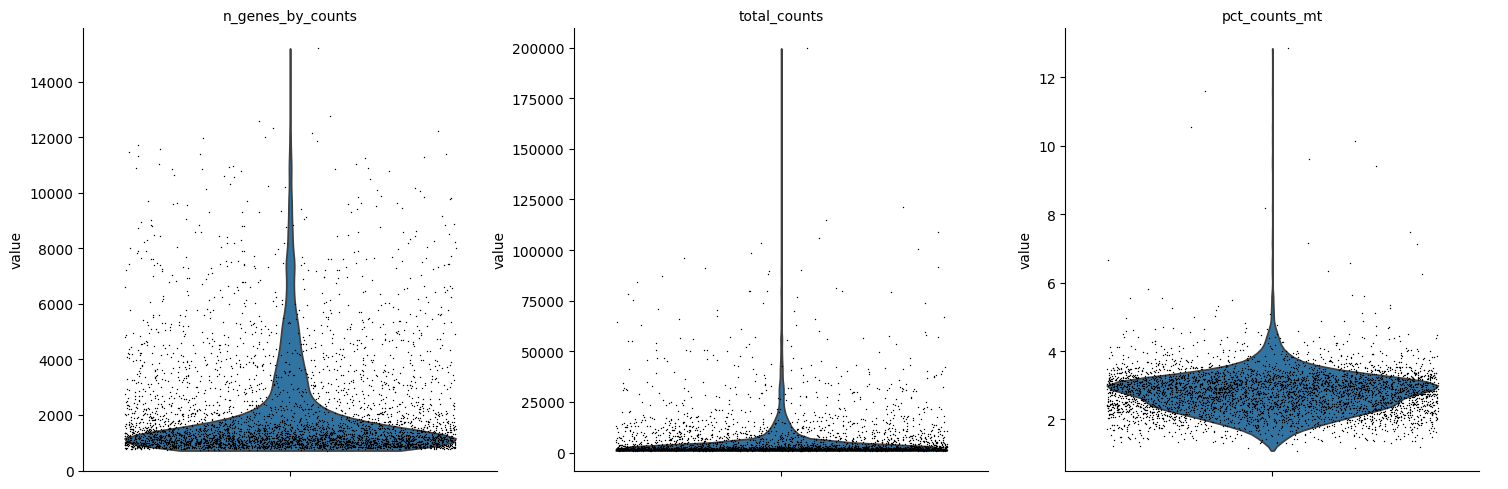


=== 过滤后平均基因数 ===
1861.5371768474033


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1174369.h5ad ===

=== 样本统计信息 ===
sample
1174369    4371
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 4371 × 30705
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1175196 =====

处理样本: 1175196_1
样本路径: /data/input/W202505270000039/scRNA-seq_v3/1175196_1/02.count/filter_matrix
成功处理样本: 1175196_1

处理样本: 1175196_2
样本路径: /data/input/W202505270000101/scRNA-seq_v3/1175196_2/02.count/filter_matrix
成功处理样本: 1175196_2

=== 合并样本组 1175196 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


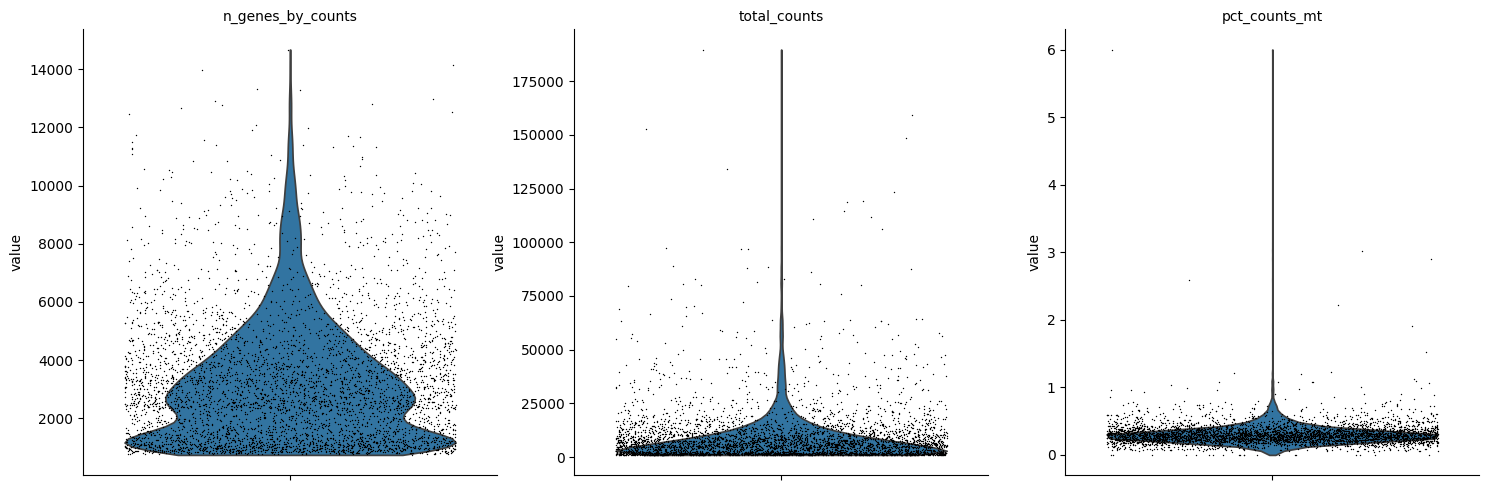


=== 过滤后平均基因数 ===
2885.9236745886656


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1175196.h5ad ===

=== 样本统计信息 ===
sample
1175196    4376
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 4376 × 30391
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1013506 =====

处理样本: 1013506_1
样本路径: /data/input/W202504290001122/scRNA-seq_v3/1013506_1/02.count/filter_matrix
成功处理样本: 1013506_1

处理样本: 1013506_2
样本路径: /data/input/W202505260007553/scRNA-seq_v3/1013506_2/02.count/filter_matrix
成功处理样本: 1013506_2

=== 合并样本组 1013506 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


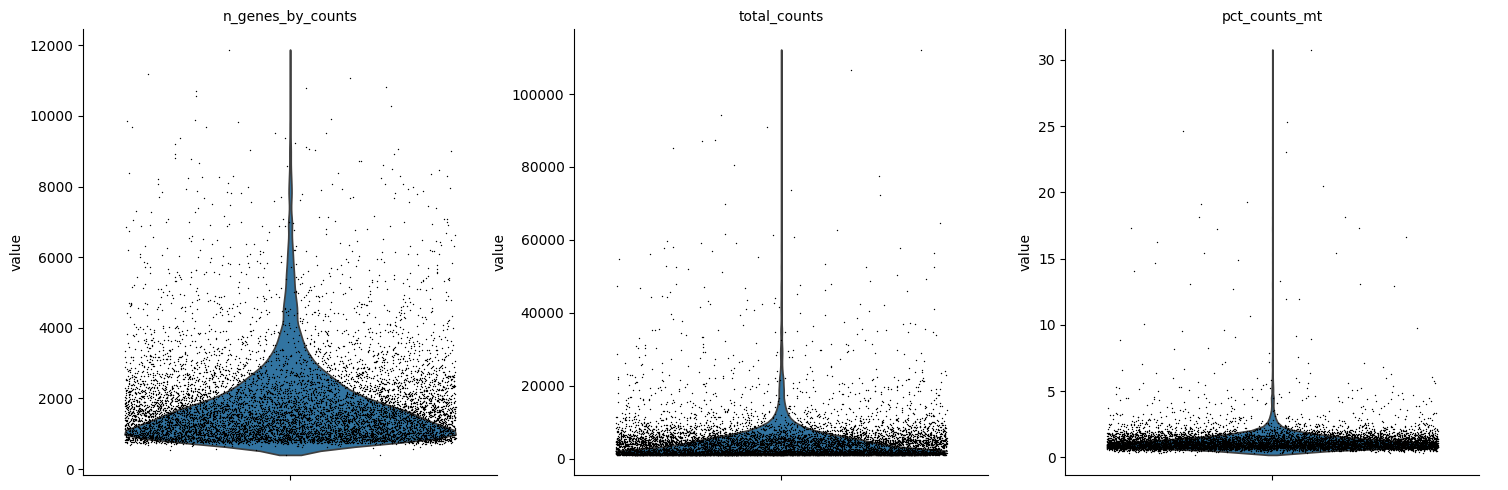


=== 过滤后平均基因数 ===
1815.022073144341


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1013506.h5ad ===

=== 样本统计信息 ===
sample
1013506    9242
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 9242 × 31976
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1175793 =====

处理样本: 1175793_1
样本路径: /data/input/W202504230034252/scRNA-seq_v3/1175793_1/02.count/filter_matrix
成功处理样本: 1175793_1

处理样本: 1175793_2
样本路径: /data/input/W202504230034244/scRNA-seq_v3/1175793_2/02.count/filter_matrix
成功处理样本: 1175793_2

=== 合并样本组 1175793 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


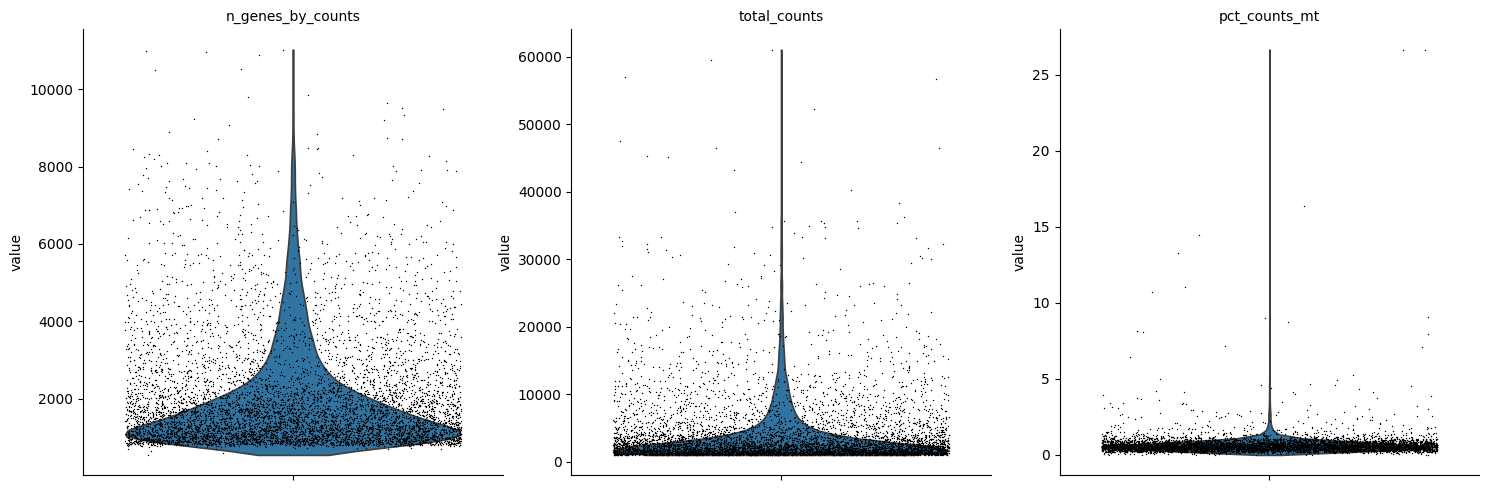


=== 过滤后平均基因数 ===
1971.949471550601


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1175793.h5ad ===

=== 样本统计信息 ===
sample
1175793    6907
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 6907 × 36536
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1175525 =====

处理样本: 1175525_1
样本路径: /data/input/W202504230034241/scRNA-seq_v3/1175525_1/02.count/filter_matrix
成功处理样本: 1175525_1

处理样本: 1175525_2
样本路径: /data/input/W202504230034231/scRNA-seq_v3/1175525_2/02.count/filter_matrix
成功处理样本: 1175525_2

=== 合并样本组 1175525 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


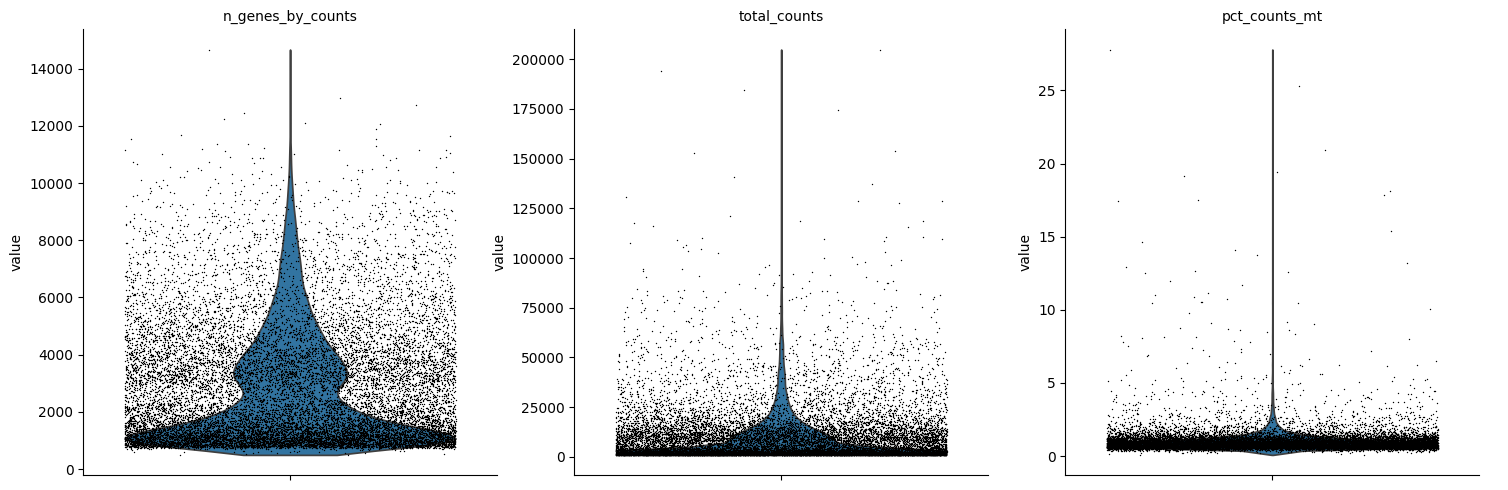


=== 过滤后平均基因数 ===
2615.1784750733136


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1175525.h5ad ===

=== 样本统计信息 ===
sample
1175525    17050
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 17050 × 32766
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1111272 =====

处理样本: 1111272_1
样本路径: /data/input/W202504220004145/scRNA-seq_v3/1111272_1/02.count/filter_matrix
成功处理样本: 1111272_1

处理样本: 1111272_2
样本路径: /data/input/W202504220004143/scRNA-seq_v3/1111272_2/02.count/filter_matrix
成功处理样本: 1111272_2

=== 合并样本组 1111272 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


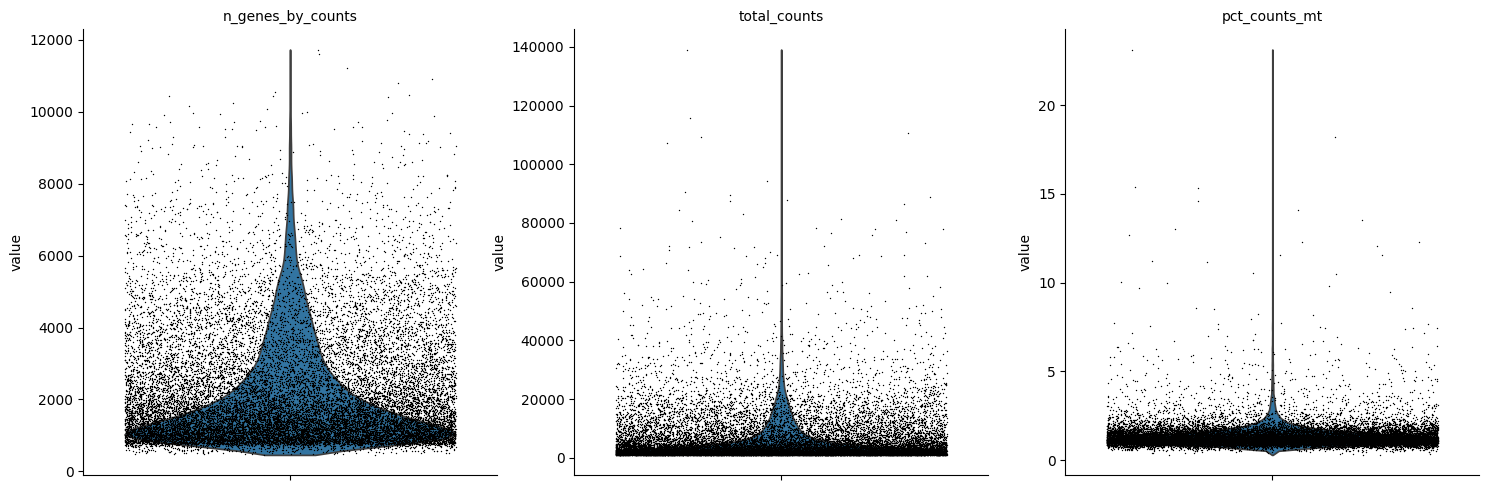


=== 过滤后平均基因数 ===
2131.5852753733475


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1111272.h5ad ===

=== 样本统计信息 ===
sample
1111272    21026
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 21026 × 32004
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1077557 =====

处理样本: 1077557_1
样本路径: /data/input/W202504160014760/scRNA-seq_v3/1077557_1/02.count/filter_matrix
成功处理样本: 1077557_1

处理样本: 1077557_2
样本路径: /data/input/W202504160014778/scRNA-seq_v3/1077557_2/02.count/filter_matrix
成功处理样本: 1077557_2

=== 合并样本组 1077557 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


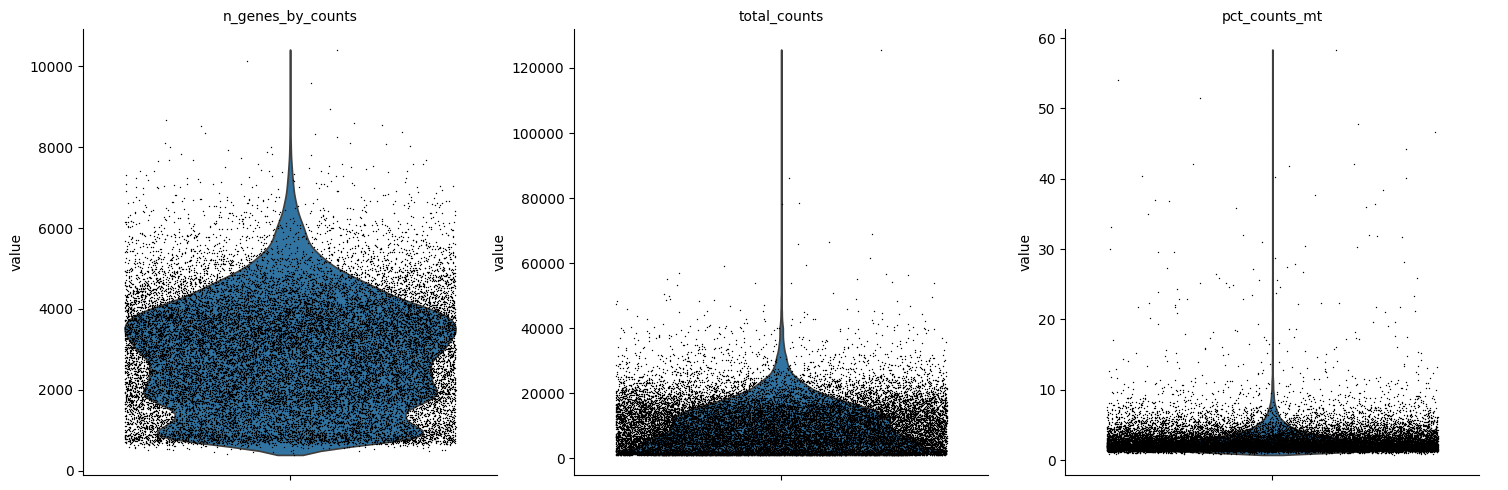


=== 过滤后平均基因数 ===
2882.6426823092506


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1077557.h5ad ===

=== 样本统计信息 ===
sample
1077557    23696
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 23696 × 35059
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1177968 =====

处理样本: 1177968_1
样本路径: /data/input/W202505080000481/scRNA-seq_v3/1177968_1/02.count/filter_matrix
成功处理样本: 1177968_1

处理样本: 1177968_2
样本路径: /data/input/W202504290001471/scRNA-seq_v3/1177968_2/02.count/filter_matrix
成功处理样本: 1177968_2

=== 合并样本组 1177968 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


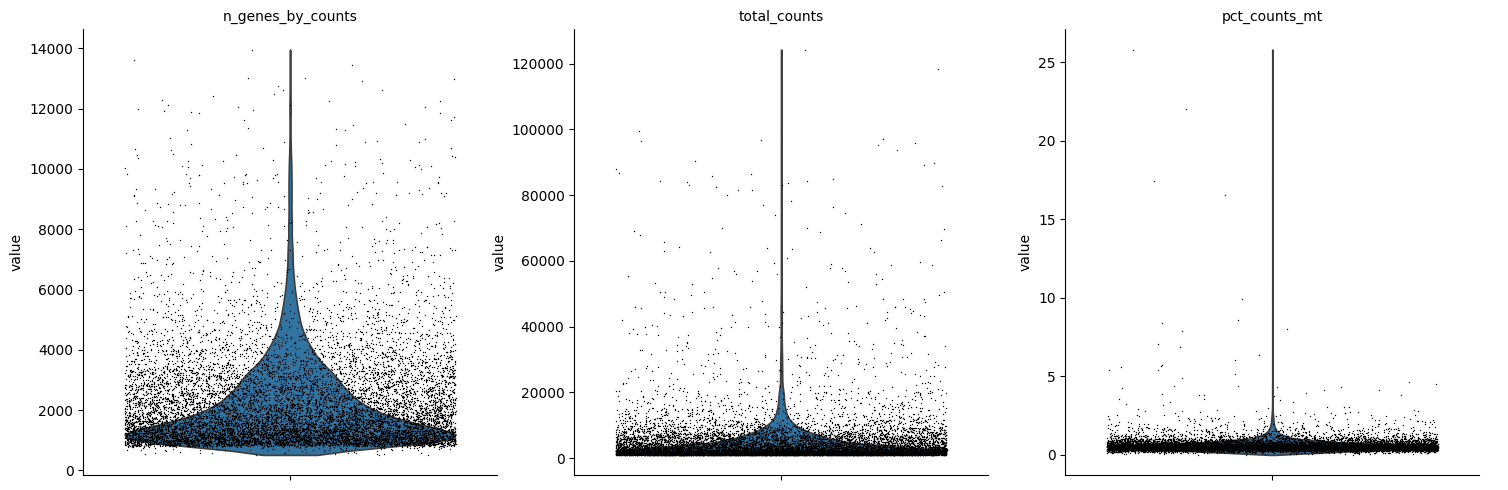


=== 过滤后平均基因数 ===
2115.7581512313564


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1177968.h5ad ===

=== 样本统计信息 ===
sample
1177968    11532
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 11532 × 36984
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1143448 =====

处理样本: 1143448_1
样本路径: /data/input/W202505060000055/scRNA-seq_v3/1143448_1/02.count/filter_matrix
成功处理样本: 1143448_1

处理样本: 1143448_2
样本路径: /data/input/W202505060000056/scRNA-seq_v3/1143448_2/02.count/filter_matrix
成功处理样本: 1143448_2

=== 合并样本组 1143448 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


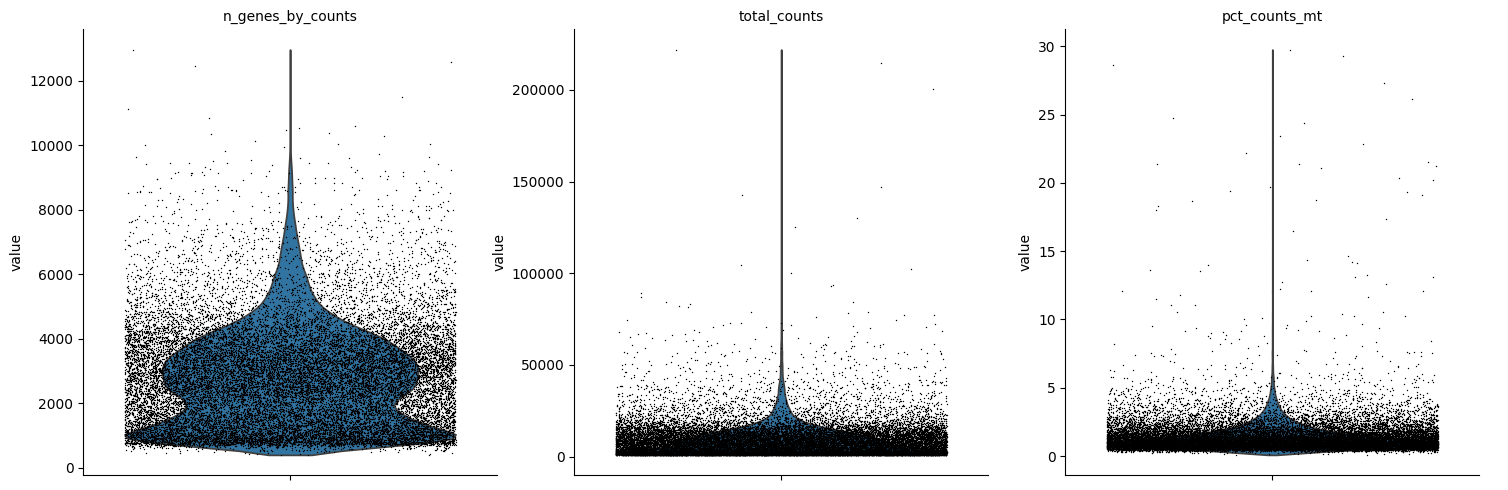


=== 过滤后平均基因数 ===
2724.8295791717164


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1143448.h5ad ===

=== 样本统计信息 ===
sample
1143448    23929
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 23929 × 34510
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1177671 =====

处理样本: 1177671_1
样本路径: /data/input/W202504290001464/scRNA-seq_v3/1177671_1/02.count/filter_matrix
成功处理样本: 1177671_1

处理样本: 1177671_2
样本路径: /data/input/W202504290001466/scRNA-seq_v3/1177671_2/02.count/filter_matrix
成功处理样本: 1177671_2

=== 合并样本组 1177671 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


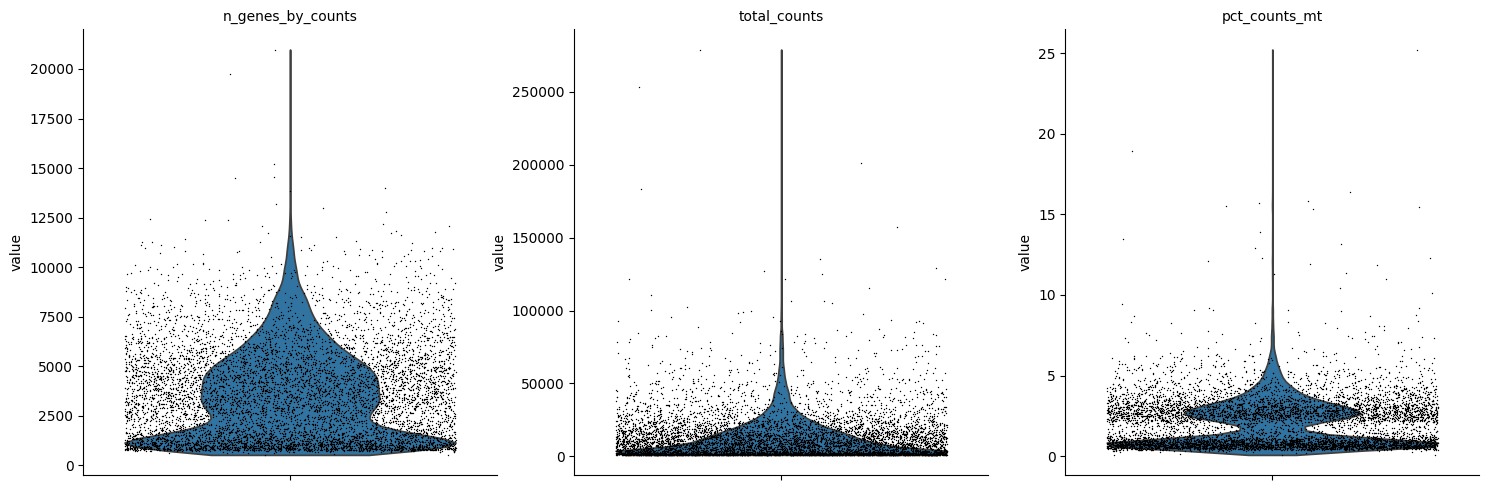


=== 过滤后平均基因数 ===
3229.683692722372


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1177671.h5ad ===

=== 样本统计信息 ===
sample
1177671    7420
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 7420 × 35184
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1178402 =====

处理样本: 1178402
样本路径: /data/input/W202505210002720/scRNA-seq_v3/1178402/02.count/filter_matrix
成功处理样本: 1178402

=== 样本组 1178402 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


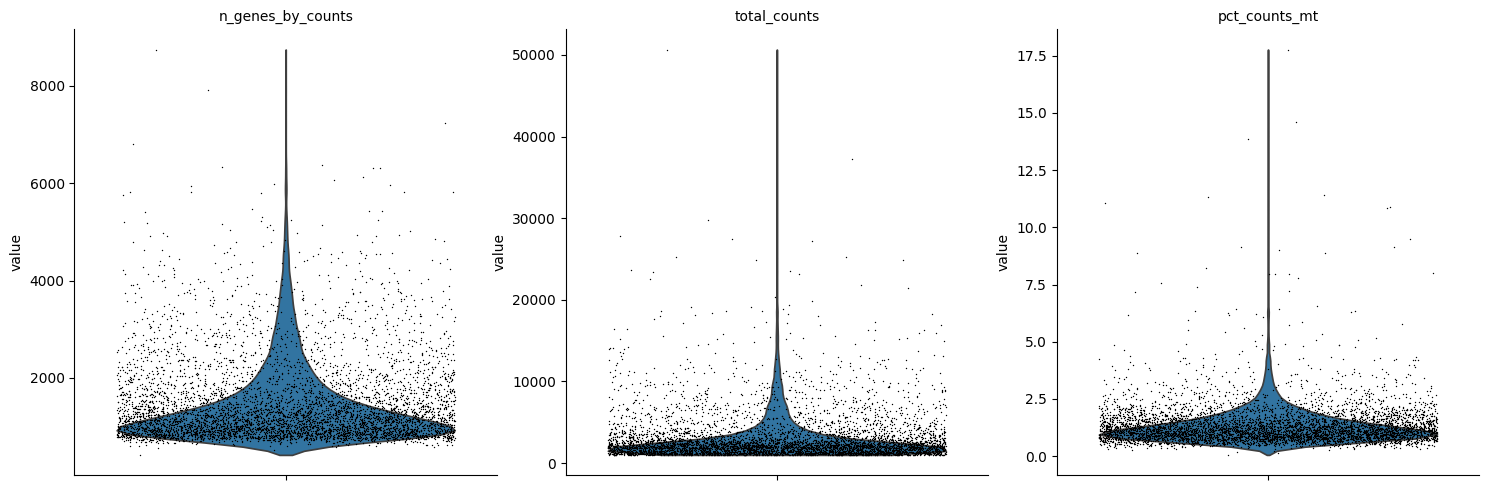


=== 过滤后平均基因数 ===
1461.4087654967698


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1178402.h5ad ===

=== 样本统计信息 ===
sample
1178402    5727
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 5727 × 29798
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 117 =====

处理样本: 117_052_1
样本路径: /data/input/W202505260004413/scRNA-seq_v3/117_052_1/02.count/filter_matrix
成功处理样本: 117_052_1

处理样本: 117_052_2
样本路径: /data/input/W202505260004408/scRNA-seq_v3/117_052_2/02.count/filter_matrix
成功处理样本: 117_052_2

=== 合并样本组 117 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


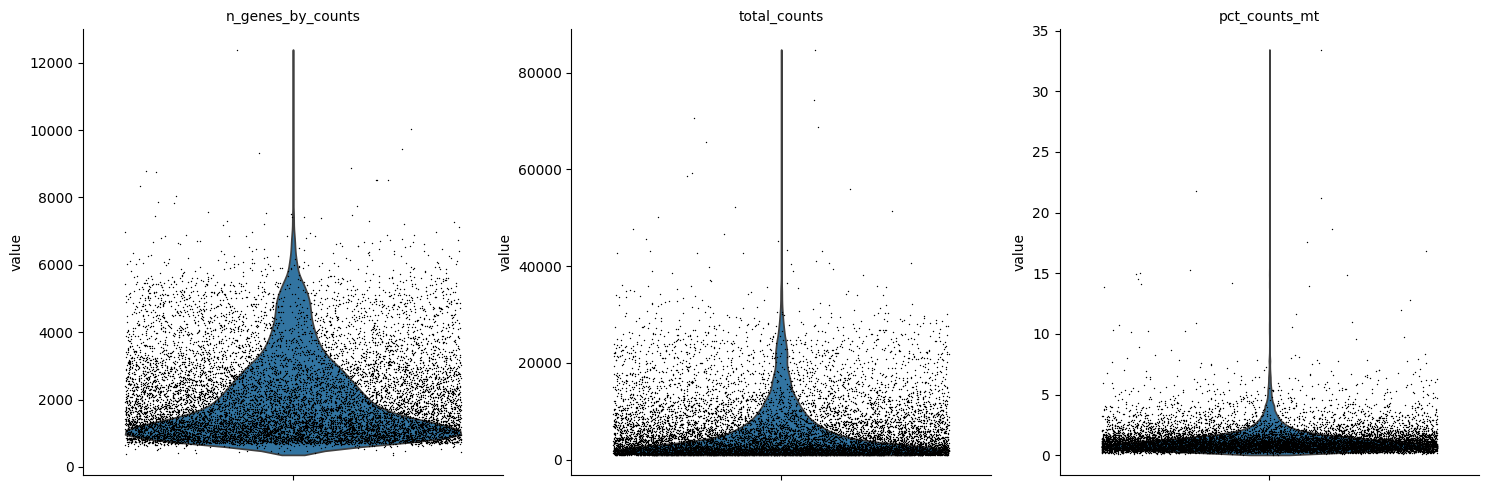


=== 结果已保存到: work/final/02_integrate_sample/single_normal/117.h5ad ===

=== 样本统计信息 ===
sample
117    12485
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 12485 × 31835
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1130425 =====

处理样本: 1130425
样本路径: /data/input/W202505210002726/scRNA-seq_v3/1130425/02.count/filter_matrix
成功处理样本: 1130425

=== 样本组 1130425 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


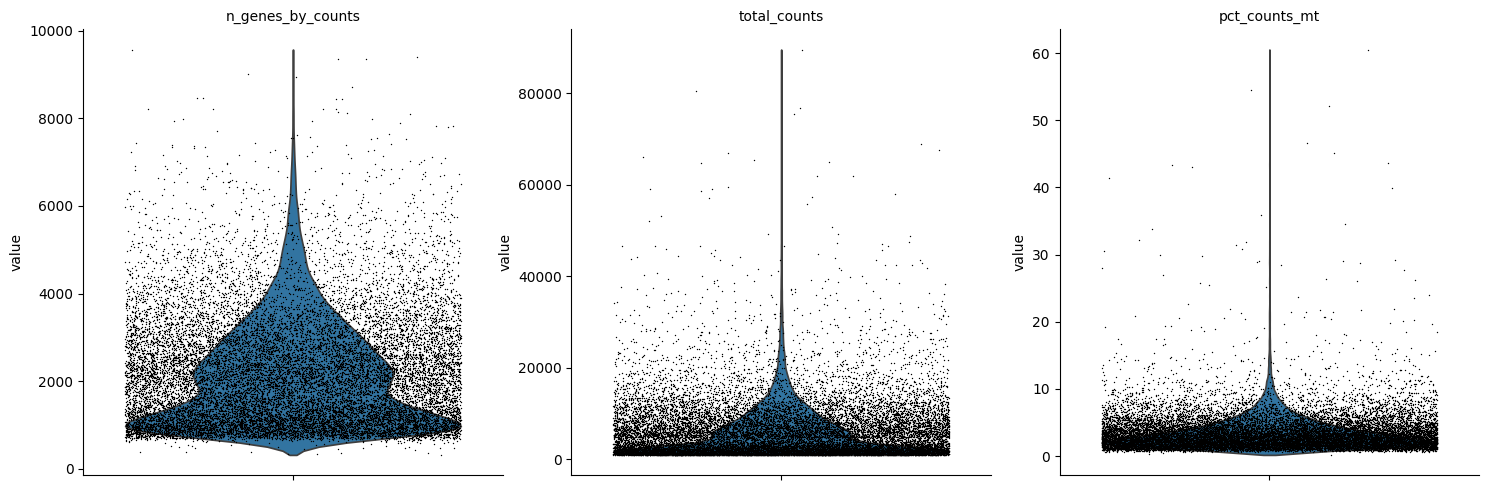


=== 过滤后平均基因数 ===
2165.2326774126022


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1130425.h5ad ===

=== 样本统计信息 ===
sample
1130425    19108
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 19108 × 36224
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1182051 =====

处理样本: 1182051_1
样本路径: /data/input/W202505260004410/scRNA-seq_v3/1182051_1/02.count/filter_matrix
成功处理样本: 1182051_1

处理样本: 1182051_2
样本路径: /data/input/W202505260004409/scRNA-seq_v3/1182051_2/02.count/filter_matrix
成功处理样本: 1182051_2

=== 合并样本组 1182051 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


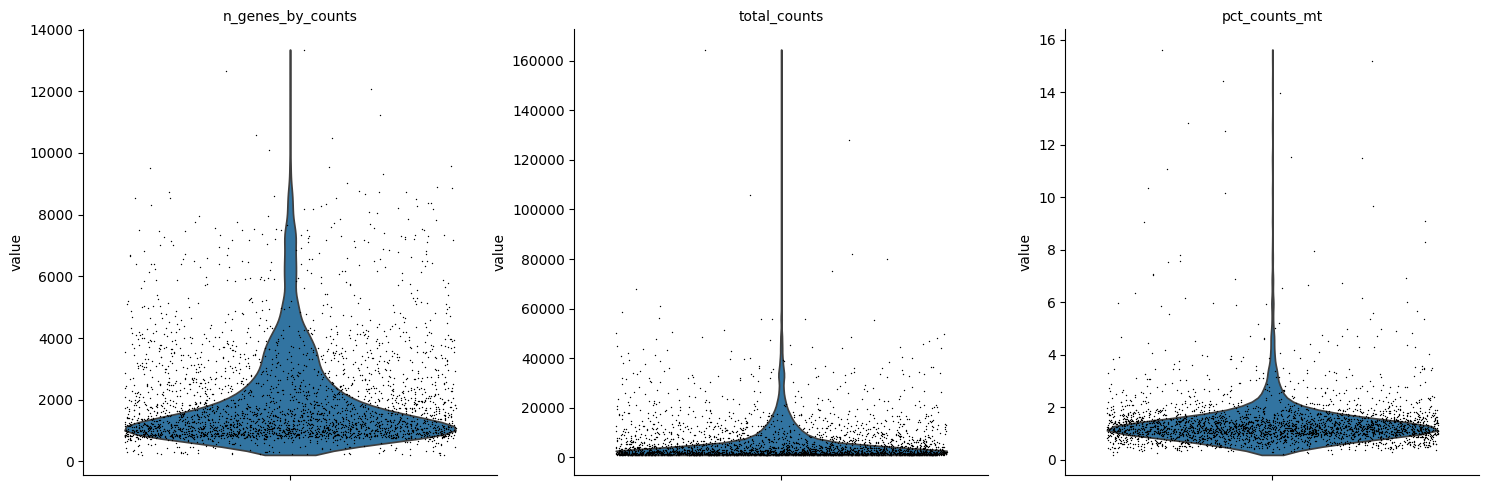


=== 过滤后平均基因数 ===
1958.4353130016052


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1182051.h5ad ===

=== 样本统计信息 ===
sample
1182051    3115
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 3115 × 26915
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1181745 =====

处理样本: 1181745_1
样本路径: /data/input/W202505260004411/scRNA-seq_v3/1181745_1/02.count/filter_matrix
成功处理样本: 1181745_1

处理样本: 1181745_2
样本路径: /data/input/W202505260004412/scRNA-seq_v3/1181745_2/02.count/filter_matrix
成功处理样本: 1181745_2

=== 合并样本组 1181745 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


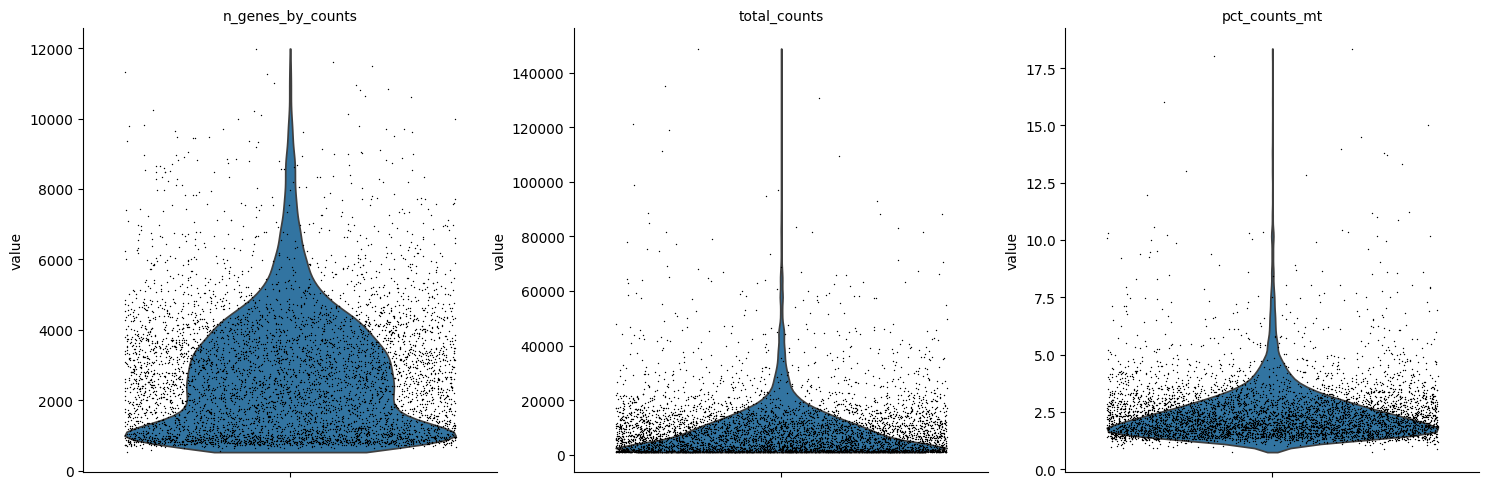


=== 过滤后平均基因数 ===
2638.7168975069253


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1181745.h5ad ===

=== 样本统计信息 ===
sample
1181745    5415
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 5415 × 33380
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1182992 =====

处理样本: 1182992_1
样本路径: /data/input/W202504290001468/scRNA-seq_v3/1182992_1/02.count/filter_matrix
成功处理样本: 1182992_1

处理样本: 1182992_2
样本路径: /data/input/W202504290001469/scRNA-seq_v3/1182992_2/02.count/filter_matrix
成功处理样本: 1182992_2

=== 合并样本组 1182992 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


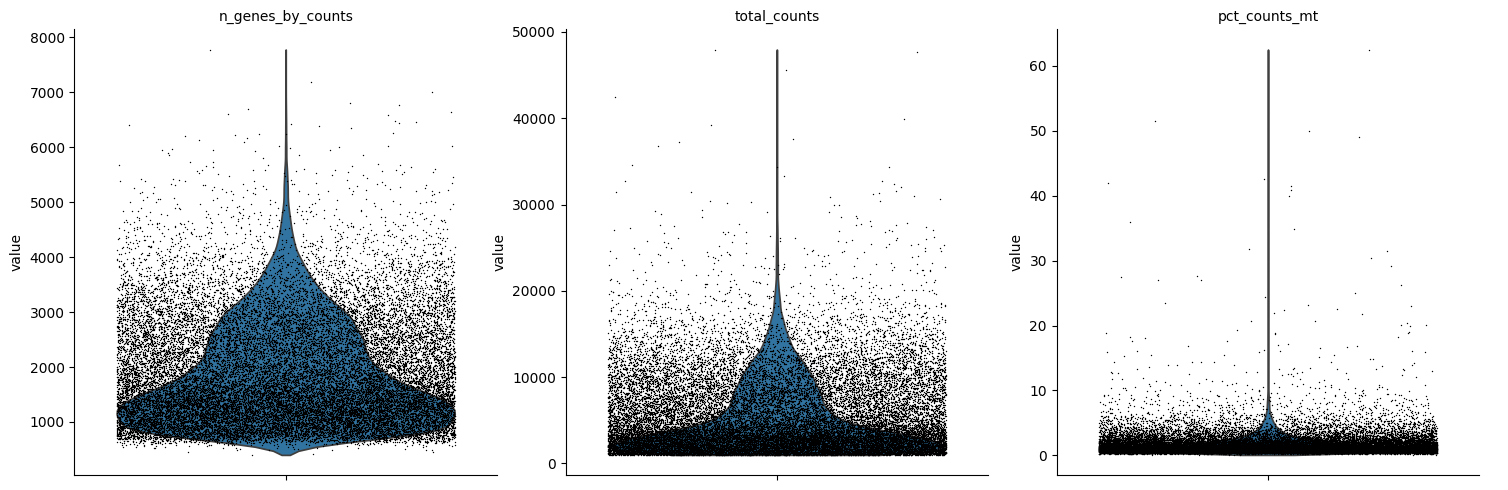


=== 过滤后平均基因数 ===
1875.528087062711


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1182992.h5ad ===

=== 样本统计信息 ===
sample
1182992    27842
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 27842 × 32685
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1179925 =====

处理样本: 1179925_1
样本路径: /data/input/W202504290001463/scRNA-seq_v3/1179925_1/02.count/filter_matrix
成功处理样本: 1179925_1

处理样本: 1179925_2
样本路径: /data/input/W202504290001465/scRNA-seq_v3/1179925_2/02.count/filter_matrix
成功处理样本: 1179925_2

=== 合并样本组 1179925 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


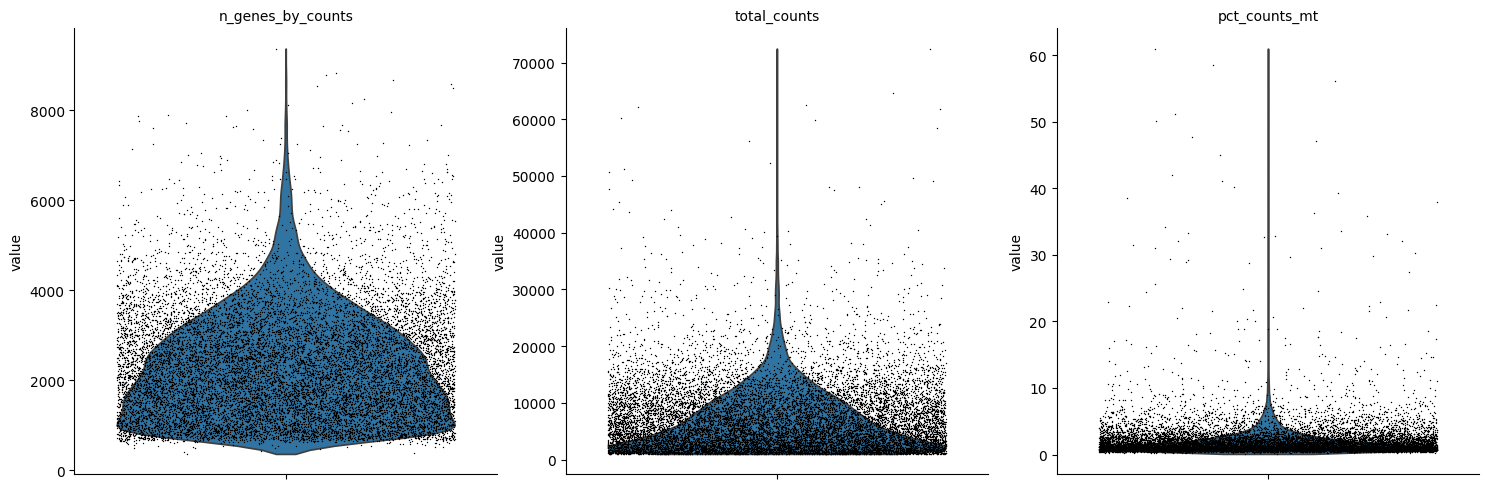


=== 过滤后平均基因数 ===
2306.711753476957


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1179925.h5ad ===

=== 样本统计信息 ===
sample
1179925    14668
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 14668 × 33339
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1184011 =====

处理样本: 1184011_1
样本路径: /data/input/W202505210002762/scRNA-seq_v3/1184011_1/02.count/filter_matrix
成功处理样本: 1184011_1

处理样本: 1184011_2
样本路径: /data/input/W202505210002761/scRNA-seq_v3/1184011_2/02.count/filter_matrix
成功处理样本: 1184011_2

=== 合并样本组 1184011 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


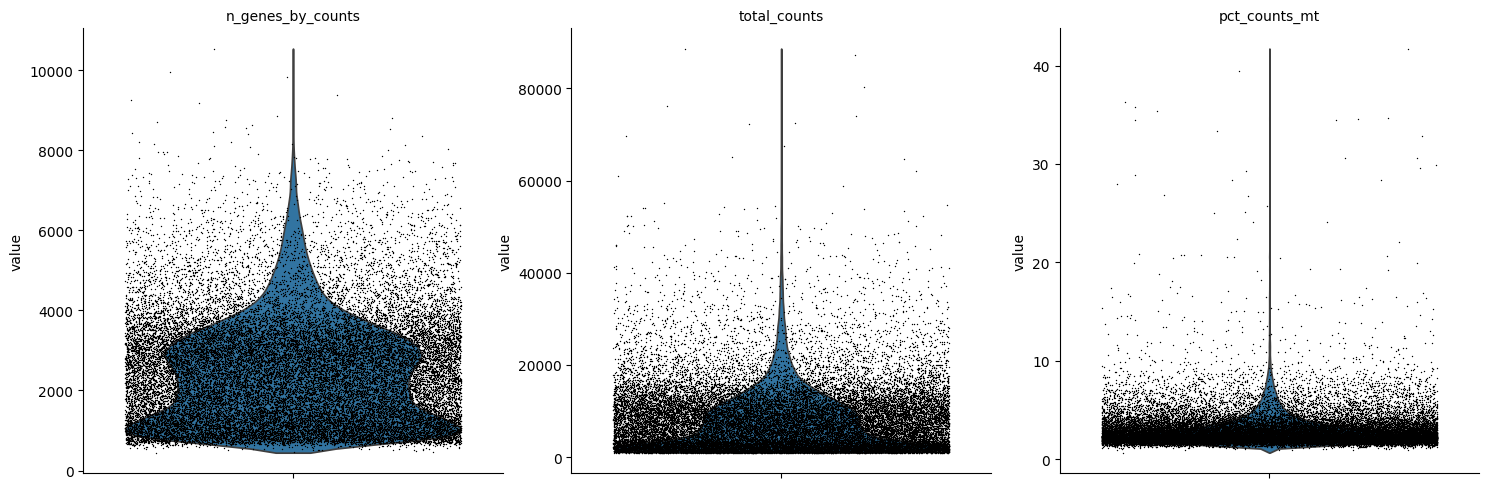


=== 过滤后平均基因数 ===
2449.112393471493


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1184011.h5ad ===

=== 样本统计信息 ===
sample
1184011    31799
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 31799 × 33472
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1185335 =====

处理样本: 1185335
样本路径: /data/input/W202505210002743/scRNA-seq_v3/1185335/02.count/filter_matrix
成功处理样本: 1185335

=== 样本组 1185335 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


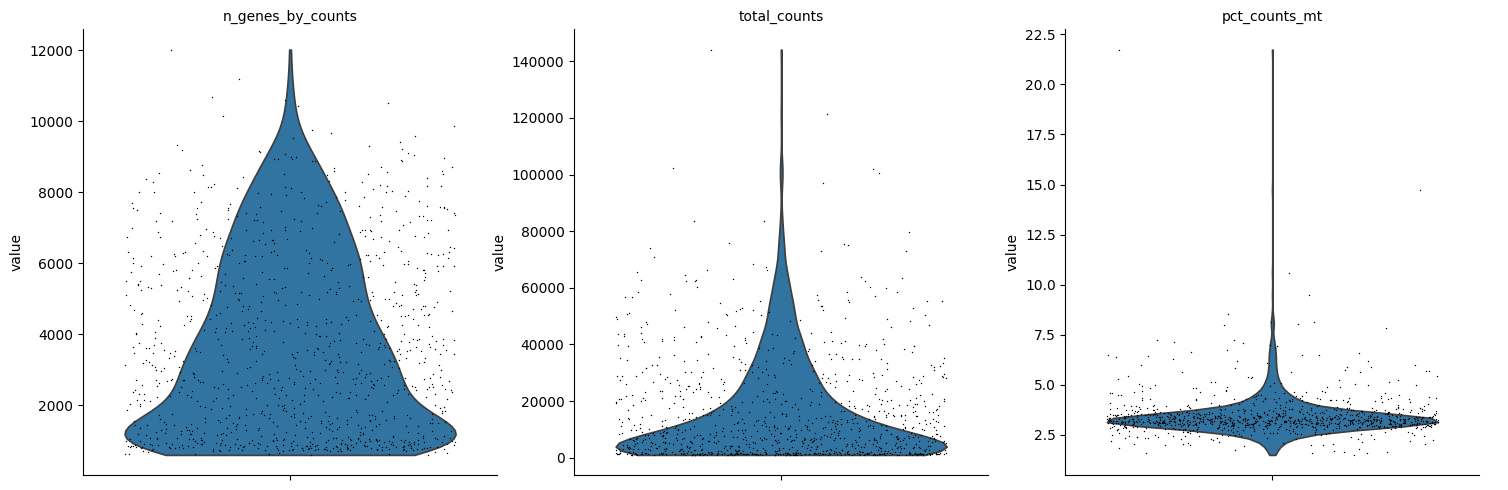


=== 过滤后平均基因数 ===
3285.6815352697095


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1185335.h5ad ===

=== 样本统计信息 ===
sample
1185335    964
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 964 × 23602
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1184859 =====

处理样本: 1184859_1
样本路径: /data/input/W202505210002750/scRNA-seq_v3/1184859_1/02.count/filter_matrix
成功处理样本: 1184859_1

处理样本: 1184859_2
样本路径: /data/input/W202505210002749/scRNA-seq_v3/1184859_2/02.count/filter_matrix
成功处理样本: 1184859_2

=== 合并样本组 1184859 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


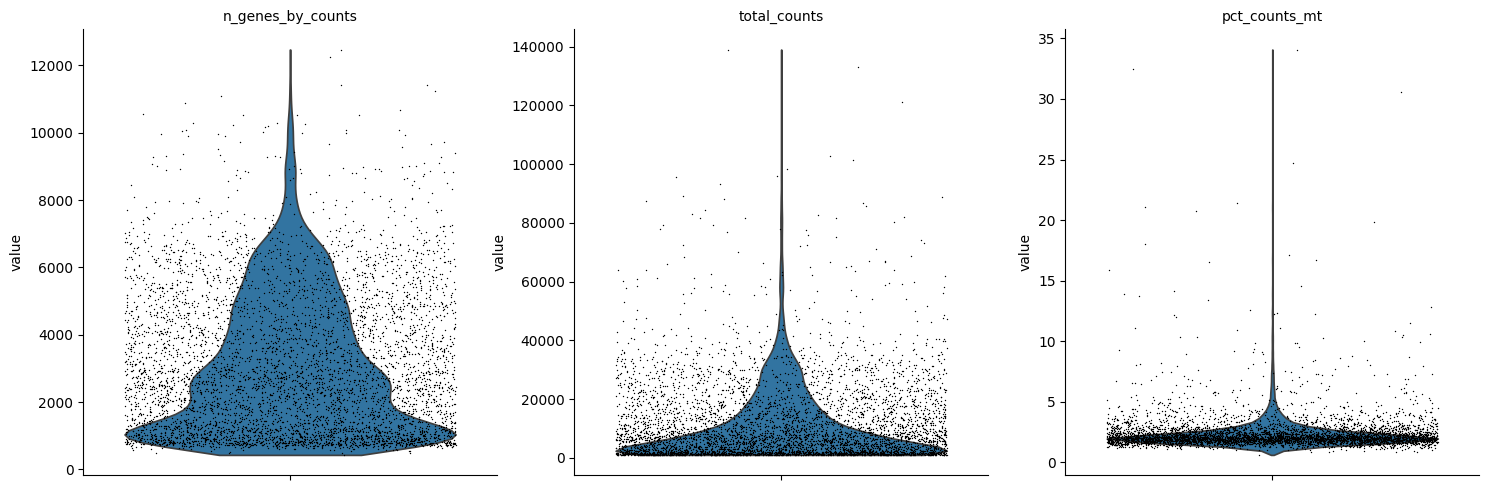


=== 过滤后平均基因数 ===
2931.937799961605


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1184859.h5ad ===

=== 样本统计信息 ===
sample
1184859    5209
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 5209 × 31485
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1184799 =====

处理样本: 1184799
样本路径: /data/input/W202505230011502/scRNA-seq_v3/1184799/02.count/filter_matrix
成功处理样本: 1184799

=== 样本组 1184799 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


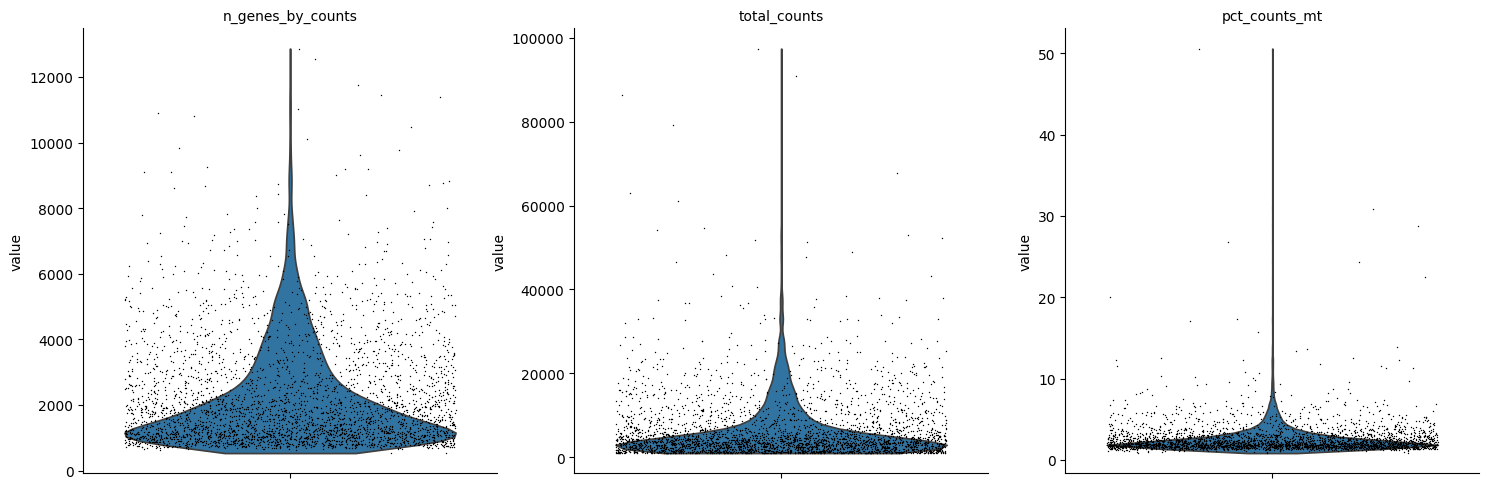


=== 过滤后平均基因数 ===
2133.724717384662


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1184799.h5ad ===

=== 样本统计信息 ===
sample
1184799    3273
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 3273 × 33529
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1185577 =====

处理样本: 1185577
样本路径: /data/input/W202505210002741/scRNA-seq_v3/1185577/02.count/filter_matrix
成功处理样本: 1185577

=== 样本组 1185577 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


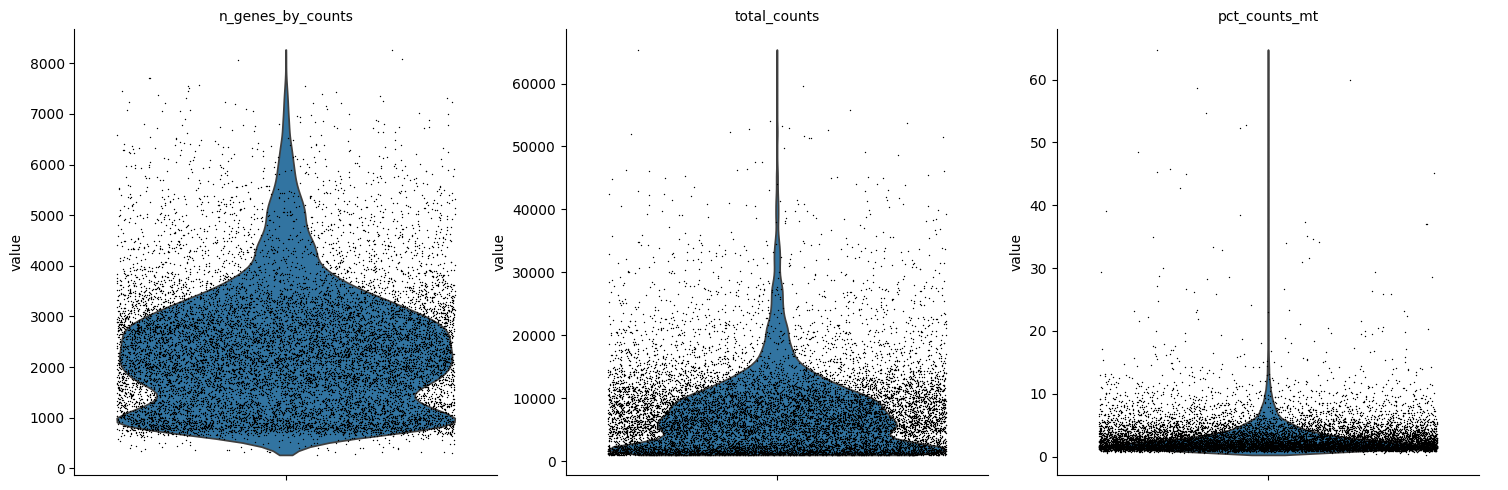


=== 过滤后平均基因数 ===
2376.6629386810646


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1185577.h5ad ===

=== 样本统计信息 ===
sample
1185577    12965
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 12965 × 30774
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1185896 =====

处理样本: 1185896
样本路径: /data/input/W202505210002742/scRNA-seq_v3/1185896/02.count/filter_matrix
成功处理样本: 1185896

=== 样本组 1185896 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


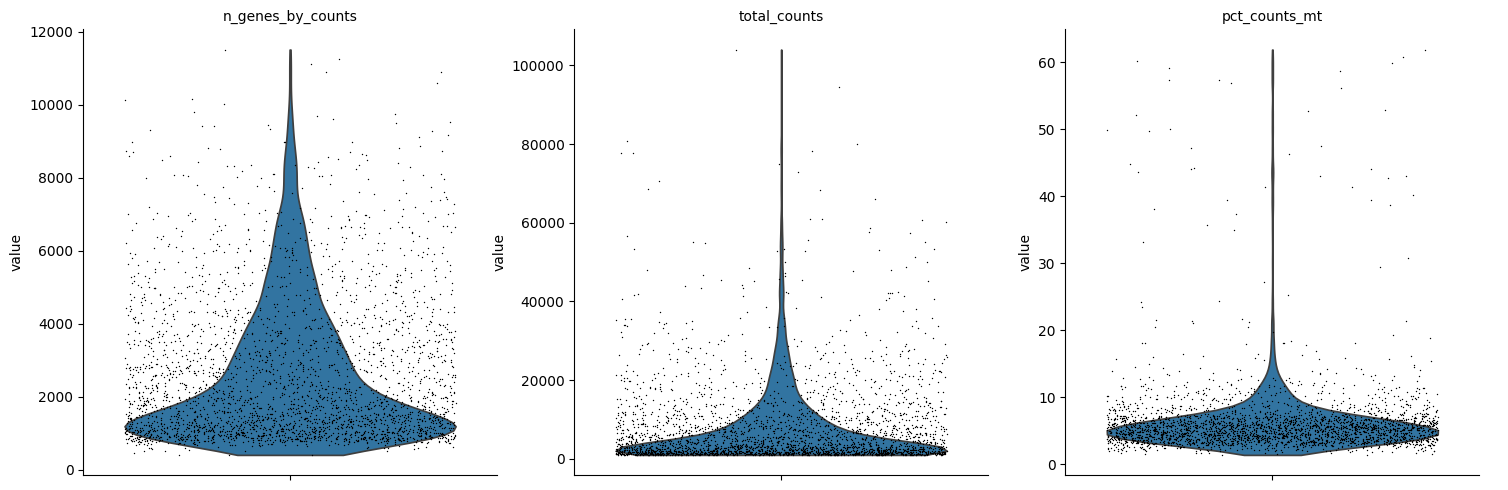


=== 过滤后平均基因数 ===
2436.2603258810154


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1185896.h5ad ===

=== 样本统计信息 ===
sample
1185896    2639
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 2639 × 28363
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1185833 =====

处理样本: 1185833
样本路径: /data/input/W202505210002746/scRNA-seq_v3/1185833/02.count/filter_matrix
成功处理样本: 1185833

=== 样本组 1185833 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


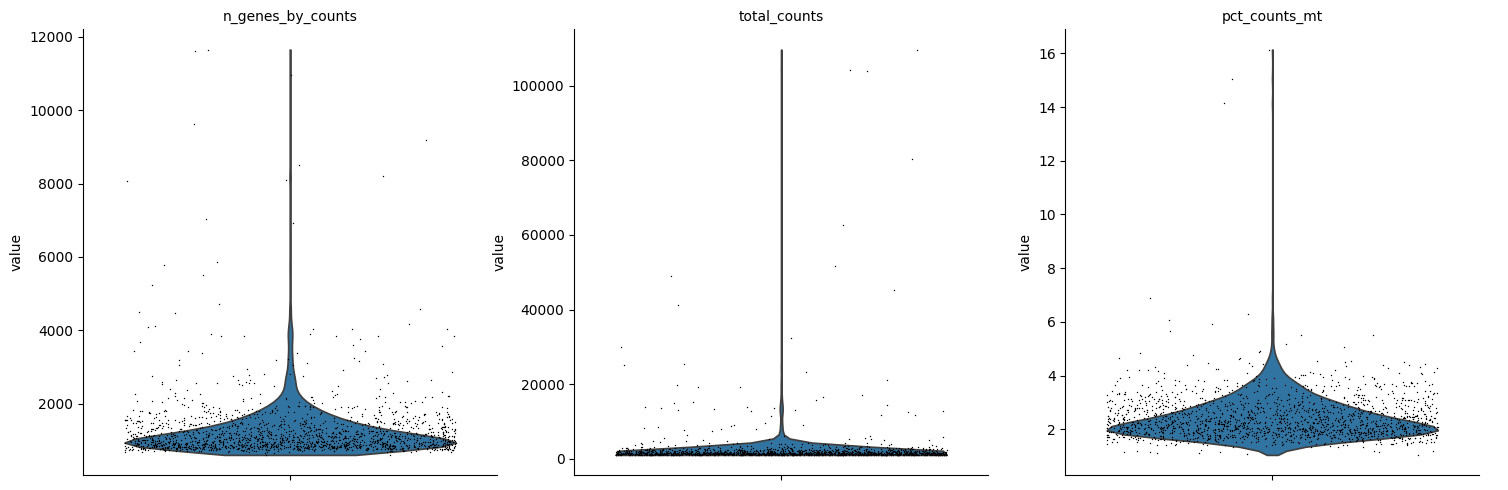


=== 过滤后平均基因数 ===
1226.1193247962747


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1185833.h5ad ===

=== 样本统计信息 ===
sample
1185833    1718
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 1718 × 18562
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1185580 =====

处理样本: 1185580
样本路径: /data/input/W202505210002765/scRNA-seq_v3/1185580/02.count/filter_matrix
成功处理样本: 1185580

=== 样本组 1185580 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


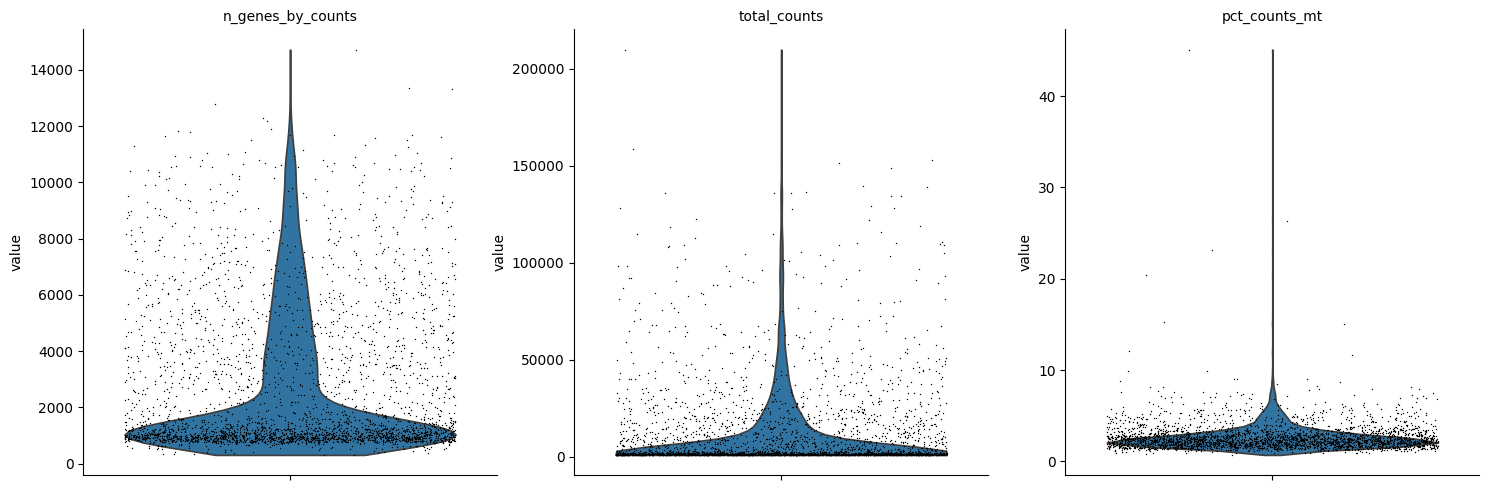


=== 过滤后平均基因数 ===
2248.757307953773


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1185580.h5ad ===

=== 样本统计信息 ===
sample
1185580    2942
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 2942 × 27913
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1185962 =====

处理样本: 1185962_2
样本路径: /data/input/W202505210002755/scRNA-seq_v3/1185962_2/02.count/filter_matrix
成功处理样本: 1185962_2

处理样本: 1185962_1
样本路径: /data/input/W202505210002757/scRNA-seq_v3/1185962_1/02.count/filter_matrix
成功处理样本: 1185962_1

=== 合并样本组 1185962 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


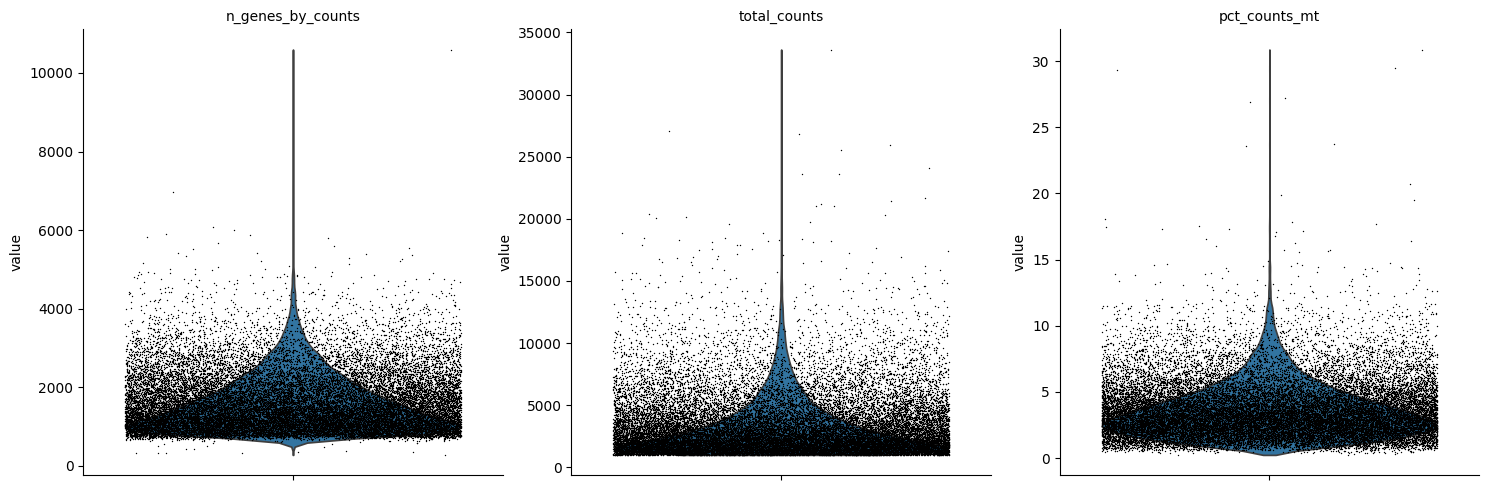


=== 过滤后平均基因数 ===
1591.4982236448698


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1185962.h5ad ===

=== 样本统计信息 ===
sample
1185962    28429
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 28429 × 37874
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1185759 =====

处理样本: 1185759_2
样本路径: /data/input/W202505230011501/scRNA-seq_v3/1185759_2/02.count/filter_matrix
成功处理样本: 1185759_2

处理样本: 1185759_1
样本路径: /data/input/W202505230011496/scRNA-seq_v3/1185759_1/02.count/filter_matrix
成功处理样本: 1185759_1

=== 合并样本组 1185759 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


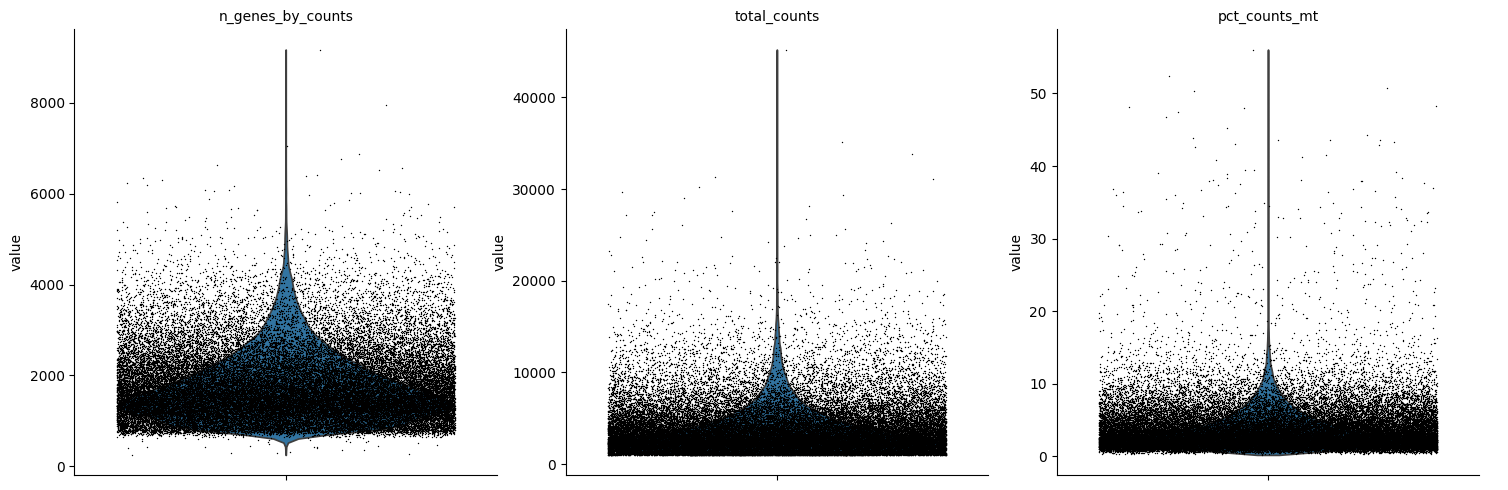


=== 过滤后平均基因数 ===
1750.4419421443624


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1185759.h5ad ===

=== 样本统计信息 ===
sample
1185759    46979
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 46979 × 37747
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1186145 =====

处理样本: 1186145_1
样本路径: /data/input/W202505210002744/scRNA-seq_v3/1186145_1/02.count/filter_matrix
成功处理样本: 1186145_1

处理样本: 1186145_2
样本路径: /data/input/W202505210002747/scRNA-seq_v3/1186145_2/02.count/filter_matrix
成功处理样本: 1186145_2

=== 合并样本组 1186145 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


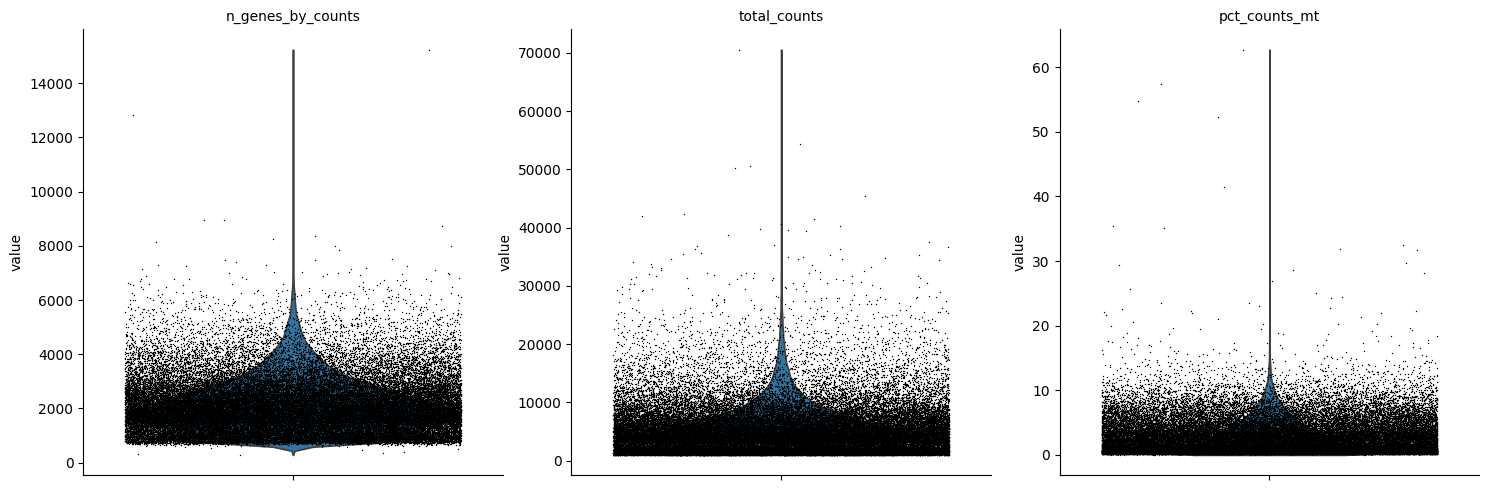


=== 过滤后平均基因数 ===
2104.37663890328


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1186145.h5ad ===

=== 样本统计信息 ===
sample
1186145    50186
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 50186 × 37097
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1186600 =====

处理样本: 1186600_1
样本路径: /data/input/W202505210002752/scRNA-seq_v3/1186600_1/02.count/filter_matrix
成功处理样本: 1186600_1

处理样本: 1186600_2
样本路径: /data/input/W202505210002751/scRNA-seq_v3/1186600_2/02.count/filter_matrix
成功处理样本: 1186600_2

=== 合并样本组 1186600 的 2 个重复 ===


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



=== 执行质量控制分析 ===

=== 生成质量控制图 ===


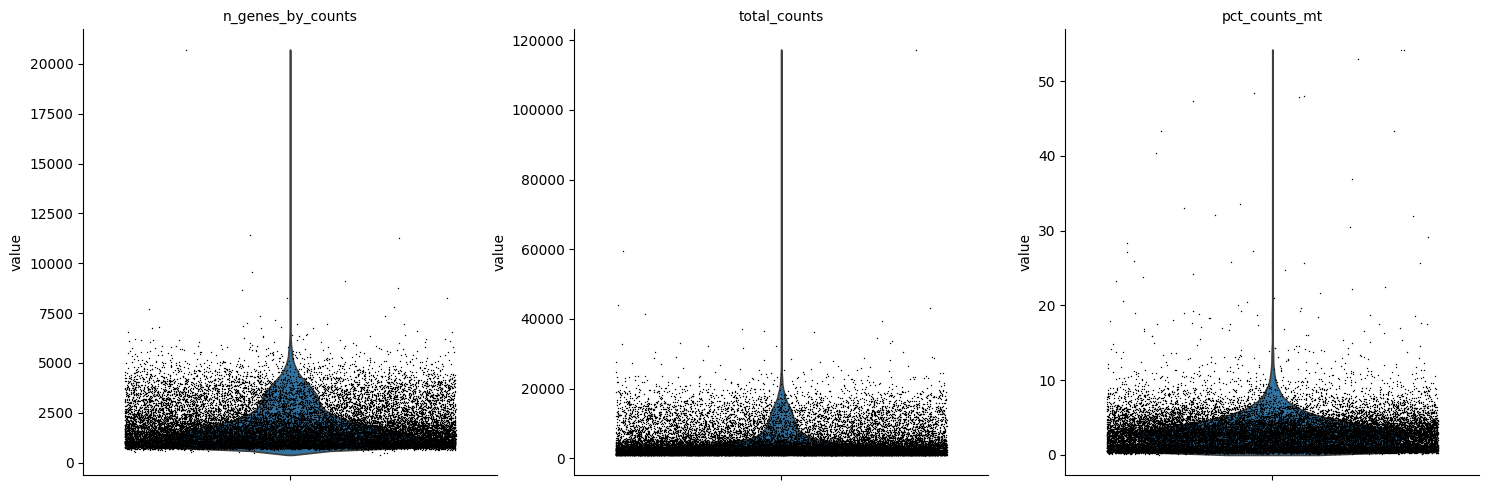


=== 过滤后平均基因数 ===
1819.201075088191


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1186600.h5ad ===

=== 样本统计信息 ===
sample
1186600    23812
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 23812 × 39085
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1186135 =====

处理样本: 1186135_1
样本路径: /data/input/W202505210002759/scRNA-seq_v3/1186135_1/02.count/filter_matrix
成功处理样本: 1186135_1

=== 样本组 1186135 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


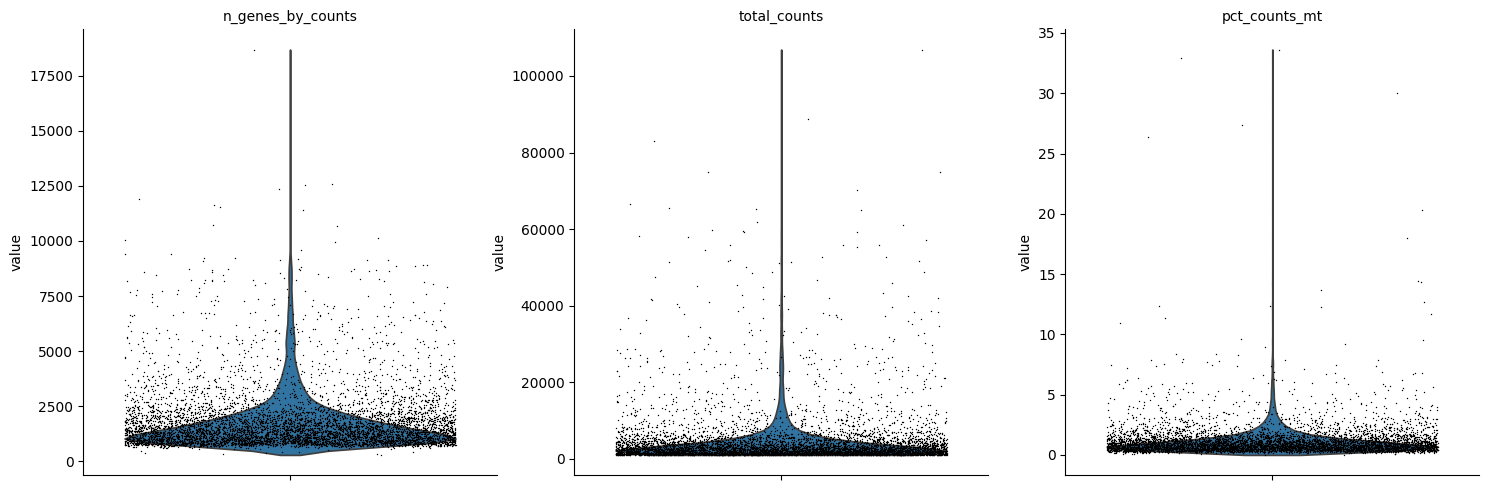


=== 过滤后平均基因数 ===
1720.7518569046536


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1186135.h5ad ===

=== 样本统计信息 ===
sample
1186135    6597
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 6597 × 36956
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

===== 开始处理样本组: 1186193 =====

处理样本: 1186193_1
样本路径: /data/input/W202505210002760/scRNA-seq_v3/1186193_1/02.count/filter_matrix
成功处理样本: 1186193_1

=== 样本组 1186193 只有1个重复，直接使用 ===

=== 执行质量控制分析 ===

=== 生成质量控制图 ===


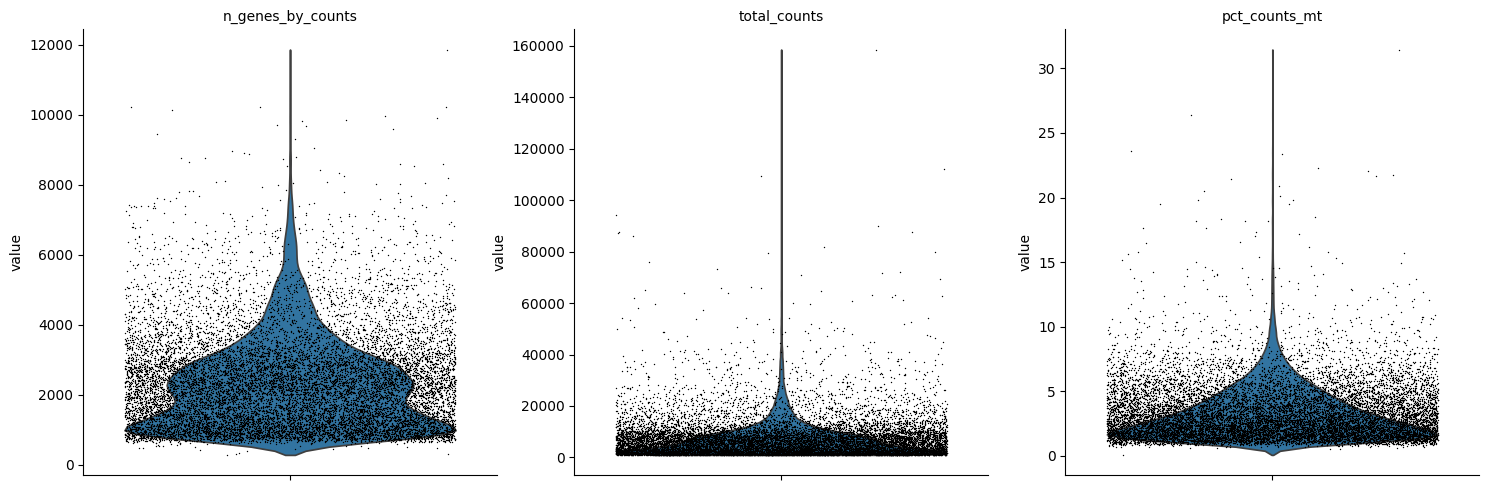


=== 过滤后平均基因数 ===
2294.346465977665


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)



=== 结果已保存到: work/final/02_integrate_sample/single_normal/1186193.h5ad ===

=== 样本统计信息 ===
sample
1186193    14417
Name: count, dtype: int64

=== 处理后的adata对象 ===
AnnData object with n_obs × n_vars = 14417 × 31359
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'


In [1]:
import scanpy as sc
import pandas as pd
from scipy.io import mmread
import anndata as ad
import os
from glob import glob
import numpy as np

def extract_project_id_from_path(path):
    """从路径中提取项目ID（如1182992）"""
    parts = path.split('/')
    sample_full = parts[-3]  # 获取如1182992_1
    project_id = sample_full.split('_')[0]  # 分割得到1182992
    return project_id

def read_10x_mtx(matrix_dir):
    """从指定目录读取10x Genomics数据"""
    try:
        barcodes_path = os.path.join(matrix_dir, "barcodes.tsv.gz")
        features_path = os.path.join(matrix_dir, "features.tsv.gz")
        matrix_path = os.path.join(matrix_dir, "matrix.mtx.gz")
        
        barcodes = pd.read_csv(barcodes_path, header=None, sep='\t')[0].values
        features = pd.read_csv(features_path, header=None, sep='\t')
        genes = features[0].values
        matrix = mmread(matrix_path).tocsr()
        adata = sc.AnnData(X=matrix.T, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=genes))
        return adata
    except Exception as e:
        print(f"读取数据出错: {str(e)}")
        return None

def process_sample_group(samples, project_id):
    """处理单个样本组（可能包含多个重复）"""
    adatas = {}
    
    # 处理每个重复样本
    for w_number, sample_full, path in samples:
        matrix_dir = path
        sample_name = sample_full  # 保留原始样本名如1182992_1
        
        print(f"\n处理样本: {sample_name}")
        print(f"样本路径: {matrix_dir}")
        
        # 检查文件是否存在
        required_files = ["barcodes.tsv.gz", "features.tsv.gz", "matrix.mtx.gz"]
        missing_files = [f for f in required_files if not os.path.exists(os.path.join(matrix_dir, f))]
        
        if missing_files:
            print(f"错误: 缺少文件: {missing_files}")
            continue
        
        # 读取数据
        sample_adata = read_10x_mtx(matrix_dir)
        if sample_adata is None:
            continue
            
        sample_adata.var_names_make_unique()
        sample_adata.obs["sample"] = project_id  # Modified: 存储纯ID（如1182992）
        sample_adata.obs["batch"] = sample_name   # Modified: 存储带重复信息的ID（如1182992_1）
        adatas[sample_name] = sample_adata
        print(f"成功处理样本: {sample_name}")
    
    if not adatas:
        print("该样本组没有有效数据")
        return None
    
    # 如果有多个重复则合并，否则直接使用
    if len(adatas) > 1:
        print(f"\n=== 合并样本组 {project_id} 的 {len(adatas)} 个重复 ===")
        adata = ad.concat(adatas.values(), label="batch")  # Modified: 使用batch_key="batch"
        adata.obs_names_make_unique()
    else:
        print(f"\n=== 样本组 {project_id} 只有1个重复，直接使用 ===")
        adata = list(adatas.values())[0]
    
    return adata

def process_samples(root_path="/data/input"):
    all_results = {}
    
    # 查找所有可能的样本目录
    sample_dirs = glob(os.path.join(root_path, "W*", "scRNA-seq_v3", "*", "02.count", "filter_matrix"))
    
    if not sample_dirs:
        print("错误: 未找到任何样本目录")
        return None
    
    # 设置工作目录
    os.makedirs(f"/data/work/final/01_single_filter/normal", exist_ok=True)
    os.chdir(f"/data/work/final/01_single_filter/normal")
    print("当前工作目录:", os.getcwd())
    
    # 按样本ID分组（去掉_1/_2后缀）
    sample_groups = {}
    for path in sample_dirs:
        parts = path.split('/')
        sample_full = parts[-3]  # 如1182992_1或1182992
        sample_base = sample_full.split('_')[0]  # 如1182992
        w_number = parts[-5]  # 如W202504290001468
        
        if sample_base not in sample_groups:
            sample_groups[sample_base] = []
        sample_groups[sample_base].append((w_number, sample_full, path))
    
    # 处理每个样本组
    for sample_base, samples in sample_groups.items():
        print(f"\n===== 开始处理样本组: {sample_base} =====")
        
        # 处理当前样本组
        adata = process_sample_group(samples, sample_base)
        if adata is None:
            continue
        
        # 质量控制分析
        print("\n=== 执行质量控制分析 ===")
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=["mt"], inplace=True, log1p=False
        )
        
        # 绘制QC图
        print("\n=== 生成质量控制图 ===")
        sc.pl.violin(
            adata,
            ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
            jitter=0.4,
            multi_panel=True,
            save=f"_QC_{sample_base}.png"
        )
        
        # 过滤
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_cells(adata, max_genes=8000)
        sc.pp.filter_genes(adata, min_cells=3)
        adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
        
        # 查看过滤后的平均基因数
        n_genes_per_cell = (adata.X > 0).sum(axis=1)
        average_genes_per_cell = np.mean(n_genes_per_cell)
        print("\n=== 过滤后平均基因数 ===")
        print(average_genes_per_cell)
        
        # 去除双胞
        sc.external.pp.scrublet(adata, batch_key="batch")  # Modified: 使用batch_key="batch"
        adata=adata[adata.obs['predicted_doublet']==False]
        
        
        # 删除线粒体基因，以及带HBB,HBA基因的细胞
        adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
        sc.pp.calculate_qc_metrics(adata, qc_vars=['hb'], inplace=True)  # Modified: 确保计算hb基因的QC指标
        #adata = adata[adata.obs['total_counts_hb'] == 0, :]

        # 从变量中删除这些基因
        genes_to_keep = ~adata.var['mt'] & ~adata.var['hb']
        #adata = adata[:, genes_to_keep]
        
        # 保存结果
        output_dir = "/data/work/final/02_integrate_sample/single_normal"
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{sample_base}.h5ad")
        adata.write_h5ad(output_path)
        print(f"\n=== 结果已保存到: {output_path} ===")
        
        # 打印样本信息
        print("\n=== 样本统计信息 ===")
        print(adata.obs["sample"].value_counts())
        print("\n=== 处理后的adata对象 ===")
        print(adata)
        
        all_results[sample_base] = adata
    
    return all_results

# 执行处理
results = process_samples()

In [ ]:
import os
import scanpy as sc

# 定义包含.h5ad文件的目录
data_dir = "/data/work/final/02_integrate_sample/single_normal"

# 获取目录中的所有.h5ad文件
h5ad_files = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]

for file in h5ad_files:
    # 读取.h5ad文件
    file_path = os.path.join(data_dir, file)
    adata = sc.read(file_path)
    
    # 确保有batch列，如果没有则创建
    if 'batch' not in adata.obs:
        adata.obs['batch'] = adata.obs['sample'].astype(str)
    else:
        # 将batch列转换为字符串类型（避免Categorical问题）
        adata.obs['batch'] = adata.obs['batch'].astype(str)
        
        # 获取唯一的batch值
        unique_batches = adata.obs['batch'].unique()
        
        if len(unique_batches) == 1:  # 如果只有一个值
            batch_value = unique_batches[0]
            if batch_value == '0':
                adata.obs['batch'] = adata.obs['sample'].astype(str) + '_1'
            elif batch_value == '1':
                adata.obs['batch'] = adata.obs['sample'].astype(str) + '_2'
            else:  # 其他单一值
                adata.obs['batch'] = adata.obs['sample'].astype(str)
        else:  # 如果有多个值
            # 创建新的batch列
            new_batch = adata.obs['sample'].astype(str).copy()
            
            # 处理0和1的情况
            mask_0 = (adata.obs['batch'] == '0')
            mask_1 = (adata.obs['batch'] == '1')
            
            new_batch[mask_0] += '_1'
            new_batch[mask_1] += '_2'
            
            # 更新batch列
            adata.obs['batch'] = new_batch
    
    # 保存修改后的文件（覆盖原文件）
    adata.write(file_path)
    print(f"已更新文件: {file}")

print("所有文件处理完成！")

已更新文件: 1077557.h5ad
已更新文件: 1184859.h5ad
已更新文件: 1178402.h5ad
已更新文件: 1182992.h5ad
已更新文件: 1175196.h5ad
已更新文件: 1175525.h5ad
已更新文件: 117.h5ad
已更新文件: 1185833.h5ad
已更新文件: 1177968.h5ad
已更新文件: 1174019.h5ad
已更新文件: 1185580.h5ad
已更新文件: 1177671.h5ad
已更新文件: 1182051.h5ad
已更新文件: 1179925.h5ad
已更新文件: 1143448.h5ad
已更新文件: 1185335.h5ad
已更新文件: 1013506.h5ad
已更新文件: 1185577.h5ad
已更新文件: 1184011.h5ad
已更新文件: 1184799.h5ad
已更新文件: 662.h5ad
已更新文件: 1175793.h5ad
已更新文件: 1181745.h5ad
已更新文件: 1111272.h5ad
已更新文件: 1185962.h5ad
已更新文件: 781.h5ad
已更新文件: 868.h5ad
已更新文件: 1174369.h5ad
已更新文件: 1185896.h5ad
已更新文件: 1130425.h5ad
已更新文件: 1174264.h5ad
所有文件处理完成！


In [1]:
import scanpy as sc
adata=sc.read('/data/work/final/02_integrate_sample/single_normal/117.h5ad')
adata.obs['batch']

CELL13_N2       117_1
CELL17_N3       117_1
CELL36_N4       117_1
CELL43_N2       117_1
CELL54_N2       117_1
                ...  
CELL78663_N1    117_2
CELL78666_N1    117_2
CELL78667_N1    117_2
CELL78668_N1    117_2
CELL78669_N1    117_2
Name: batch, Length: 6802, dtype: category
Categories (2, object): ['117_1', '117_2']

In [8]:
import scanpy as sc
adata=sc.read('/data/work/final/02_integrate_sample/single_samples_delete_genes/1125687.h5ad')
del adata.obs['experiment']
adata.obs['experiment']='v2.5'
adata.write('/data/work/final/02_integrate_sample/single_samples_delete_genes/1125687.h5ad')

In [9]:
adata.obs['experiment']

CELL1_N1        v2.5
CELL2_N1        v2.5
CELL3_N1        v2.5
CELL4_N1        v2.5
CELL5_N1        v2.5
                ... 
CELL24327_N1    v2.5
CELL24328_N1    v2.5
CELL24329_N1    v2.5
CELL24330_N1    v2.5
CELL24331_N1    v2.5
Name: experiment, Length: 45663, dtype: category
Categories (1, object): ['v2.5']

In [3]:
import os
import scanpy as sc

# 定义包含.h5ad文件的目录
data_dir = "/data/work/final/02_integrate_sample/single_samples_delete_genes"

# 获取目录中的所有.h5ad文件
h5ad_files = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]

for file in h5ad_files:
    # 读取.h5ad文件
    file_path = os.path.join(data_dir, file)
    adata = sc.read(file_path)
    
    adata.obs['experiment']='v3'
    
    # 保存修改后的文件（覆盖原文件）
    adata.write(file_path)
    print(f"已更新文件: {file}")

print("所有文件处理完成！")

已更新文件: 1186145.h5ad
已更新文件: 1143448.h5ad
已更新文件: 1125687.h5ad
已更新文件: 1013506.h5ad
已更新文件: 1185335.h5ad
已更新文件: 1185580.h5ad
已更新文件: 1174019.h5ad
已更新文件: 1177671.h5ad
已更新文件: 1179925.h5ad
已更新文件: 1182051.h5ad
已更新文件: 1184799.h5ad
已更新文件: 1184011.h5ad
已更新文件: 1181745.h5ad
已更新文件: 662.h5ad
已更新文件: 1175793.h5ad
已更新文件: 1185577.h5ad
已更新文件: 1185962.h5ad
已更新文件: 781.h5ad
已更新文件: 1111272.h5ad
已更新文件: 868.h5ad
已更新文件: 1186135.h5ad
已更新文件: 1174369.h5ad
已更新文件: 1130425.h5ad
已更新文件: 1185896.h5ad
已更新文件: 1174264.h5ad
已更新文件: 1178402.h5ad
已更新文件: 1182992.h5ad
已更新文件: 1175196.h5ad
已更新文件: 1184859.h5ad
已更新文件: 1185759.h5ad
已更新文件: 1077557.h5ad
已更新文件: 1186600.h5ad
已更新文件: 1125175.h5ad
已更新文件: 1175525.h5ad
已更新文件: 117.h5ad
已更新文件: 1177968.h5ad
已更新文件: 1186193.h5ad
已更新文件: 1185833.h5ad
所有文件处理完成！


In [1]:
import scanpy as sc
adata=sc.read('/data/work/final/02_integrate_sample/single_samples_delete_genes/1111272.h5ad')

In [2]:
adata

AnnData object with n_obs × n_vars = 21026 × 31964
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'experiment'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hb'
    uns: 'scrublet'

In [4]:
sc.external.pp.scrublet(adata, batch_key="batch")

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


In [13]:
sc.pp.scrublet(adata,batch_key="batch",threshold=0.2)

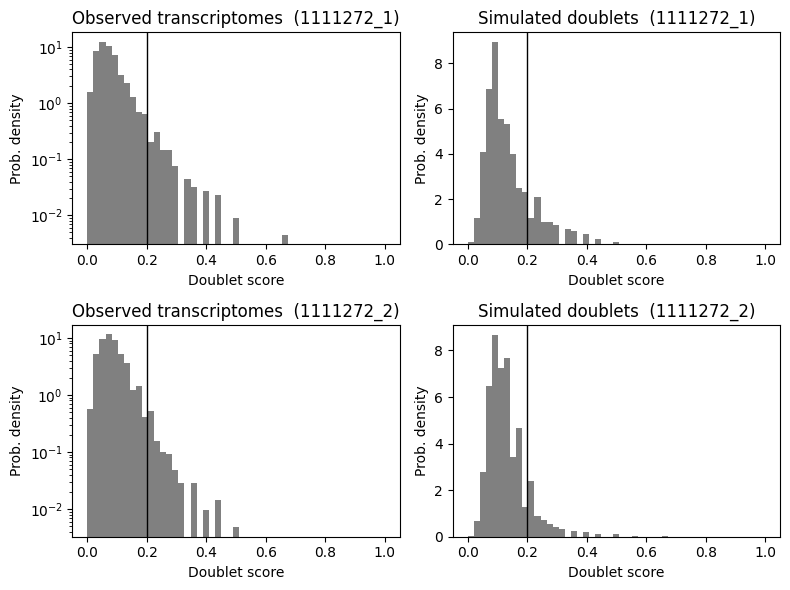

In [ ]:
sc.pl.scrublet_score_distribution(adata)